#### 0)  Introduction:

This demonstration notebook contains part of the work contributed to my Master of Data Science final thesis project, which aimed to use deep learning models and remote sensing data (satellite image time series or grid-point based time series of specified spatial resolution, Bi-directional ConvLSTM with multi-head self-attention as encoders for multi-channel input features, and 3D-Transpose convolution for the decoder to give pixelwise predicted values). 

The concept of this thesis project was based on the climate feedback:   occurrences of wildfires and local weather patterns in both long and short term are believed to be correlated in a way manifesting properties of positive feedbacks (e.g., wildfires would cause loss in vegetation covers and abrupt emissions of smoke particles into the atmoshpere, which might bring short-term impacts of varying the flow of winds and local cooling due to increased amounts of solar radiative heat scattering or reflecting on top of atmosphere, while in long term decrease in tree evapotranspiration would cause more severe droughts and would in return increase the chances of wildfires). Therefore, the setting for evaluation would comprise of 2 parts:  
<ol><li>Inputs: wildfire burned pixels and gridded weather observations within a lagged time period <br>
        Output: binary pixelwise classification of wildfire occurrences at the forecasted timestep + geographical land cover variables (long-term)</li><br>
    <li>Inputs 1: wildfire burned pixels within a lagged time period + geographical land cover variables (long-term)<br>
        Inputs 2: wildfire burned pixels and gridded weather observations within a lagged time period + geographical land cover variables (long-term)<br>
        Output: gridded weather observations (surface temperature & precipitations) at the forecasted timestep</li></ol>

#### 1)  Defining targeted region & Data collection:

For this project, the targeted study region covered the southern edge of the Amazon Rainforest, the grassland and sub-tropical forest located in central Brazil, and the highlands within the borders of Bolivia and Paraguay. This was one of the areas of the highest wildfire activities in the South America, mostly due to logging to serve purposes of agricultural cultivation and urban expansion. From below, 20 grids were selected, each was of size 5 degree x 5 degree in terms of latitude and longitude scales. Besides, a larger window was defined by extending the outer boundary of the 20 grids of land areas by 10 degrees in all four directions. The difference between the large window and the 20 smaller grids was that land-based variables, like the evapotranspiration and surface albedo, would be collected only on the 20 squared areas, while atmospheric condition variables would cover the whole large window. The assumption behind this was that weather conditions in the neighbouring and surrounding areas could have impacts on the accuracy of predicting the wildfire spreads or outbreaks in the enclosed centric regions. 

Depending on the pre-set spatial resolution of these grids and the window (e.g. 500 m per pixel or 1 km per pixel, etc., referring to the below table for all spatial and temporal resolutions of the data products used in this project), data would be downloaded from the Google Earth Engine, MODIS satellite image products and ERA5 climate model simulation of weather observations were retrieved. 

<br>

<table>
<thead>
  <th>MODIS Data Product</th>
  <th>Feature Layers of Interest</th>	
  <th>Spatial Resolution</th>
  <th>Temporal Resolution</th>
</thead>
<tbody>
  <tr>
  <td>MOD14A1.006 /	<br>MCD64A1.006</td>
  <td>-	Binarized burned area (Not burned = 0; Burned = 1)<br>
      -	Maximum radiative fire power (RFP)</td>
  <td>1 km / 500 m</td>
  <td>Daily / Monthly</td>
  </tr>
  <tr>
  <td>MOD13A1.006</td>
  <td>-	Normalised Difference Vegetation Index (NDVI)</td>
  <td>500 m</td>
  <td>16 days <br>
      (Take one per every two consecutive images) <br> 
      (Donwscale to monthly interval)</td>
  </tr>
  <tr>
  <td>MOD08_M3.061</td>
  <td>-	Mean Aerosol Optical Depth (AOD) (for land and ocean)<br>
      -	Mean Cloud Optical Thickness</td>
  <td>1º in latitude or longitude<br>
      (roughly 110 km at equator)</td>
  <td>Monthly</td>
  </tr>
  <tr>
  <td>MCD12Q1.006</td>
  <td>-	International Geosphere-Biosphere Programme (IGBP) classification for land cover types</td>
  <td>500 m</td>
  <td>Yearly</td>
  </tr>
</tbody>
</table>

<br>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import seaborn as sns

In [ ]:
## latitude and longitude coordinates of the 20 square grids
amz_points_boundary = [
(-62.0, -57.0, -27.0, -22.0),
(-62.0, -57.0, -22.0, -17.0),
(-57.0, -52.0, -27.0, -22.0),
(-57.0, -52.0, -22.0, -17.0),

(-62.0, -57.0, -17.0, -12.0),
(-62.0, -57.0, -12.0, -7.0),
(-57.0, -52.0, -17.0, -12.0),
(-57.0, -52.0, -12.0, -7.0),

(-72.0, -67.0, -17.0, -12.0),
(-72.0, -67.0, -12.0, -7.0),
(-67.0, -62.0, -17.0, -12.0),
(-67.0, -62.0, -12.0, -7.0),

(-52.0, -47.0, -23.0, -18.0),
(-52.0, -47.0, -18.0, -13.0),
(-47.0, -42.0, -23.0, -18.0),
(-47.0, -42.0, -18.0, -13.0),

(-52.0, -47.0, -13.0, -8.0),
(-52.0, -47.0, -8.0, -3.0),
(-47.0, -42.0, -13.0, -8.0),
(-47.0, -42.0, -8.0, -3.0)
]

## extend 10 degrees
amz_weather_window = (-72.0 - 10.0, 
                      -42.0 + 10.0,
                      -27.0 - 10.0,
                      -7.0 + 10.0)

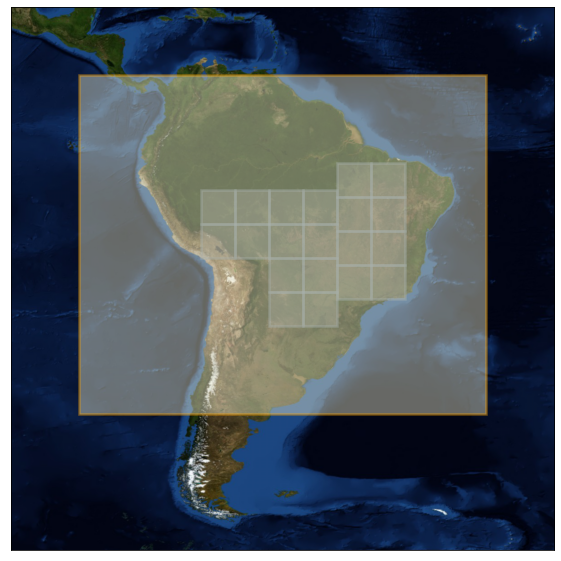

In [ ]:
## visualization on map
plt.figure(figsize=(12,10))
m = Basemap(width=2e6,height=9e6,resolution='h',
            llcrnrlon=-100,llcrnrlat=-60,urcrnrlon=-20,urcrnrlat=20)
m.bluemarble()

## rectangular boxes
## fire active area window
m_rect = []
for n in range(len(amz_points_boundary)):
    x1, y1 = m(amz_points_boundary[n][0], amz_points_boundary[n][2])
    x2, y2 = m(amz_points_boundary[n][0], amz_points_boundary[n][3])
    x3, y3 = m(amz_points_boundary[n][1], amz_points_boundary[n][3])
    x4, y4 = m(amz_points_boundary[n][1], amz_points_boundary[n][2])
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='grey',edgecolor='slategrey',linewidth=2.5,alpha=0.4)
    plt.gca().add_patch(poly)

## meteorological window
x1, y1 = m(-90.0, -40.0)
x2, y2 = m(-90.0, 10.0)
x3, y3 = m(-30.0, 10.0)
x4, y4 = m(-30.0, -40.0)
poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='lightyellow',edgecolor='orange',linewidth=2.5,alpha=0.4)
plt.gca().add_patch(poly)

plt.show()

In [ ]:
import json
import pickle
import os
import cv2
import gdal
import copy
import time
from google.colab.patches import cv2_imshow
from collections import Counter
from datetime import datetime, date, timedelta

In [ ]:
## function in case of further splitting the square grid size (default 5 degree x 5 degree)
## get also central point and label for each unit of split grids

def grid_split(grid_list, split_size):
    land_grid = []
    land_point = []
    land_grid_label = []
    for grid in grid_list:
        grid_local = []
        point_local = []
        for gx in range(0, int(grid[1] - grid[0])):
            for gy in range(0, int(grid[3] - grid[2])):
                lat_low = grid[2] + gy
                lat_high = grid[2] + gy + 1
                lon_low = grid[0] + gx
                lon_high = grid[0] + gx + 1
                grid_label = str(lat_low) + "-" + str(lat_high) + "-" + str(lon_low) + "-" + str(lon_high) + "-"
                land_grid_label.append(grid_label)
                temp_per_grid = []
                temp_central_point_per_grid = []
                for x in np.arange(0, 1, split_size):
                    for y in np.arange(0, 1, split_size):
                        temp_per_grid.append((grid[0] + gx + x, 
                                              grid[0] + gx + x + split_size,
                                              grid[2] + gy + y,
                                              grid[2] + gy + y + split_size))
                        poi_y = round(grid[2] + gy + y + split_size/2, 2)
                        poi_x = round(grid[0] + gx + x + split_size/2, 2)
                        temp_central_point_per_grid.append([poi_x, poi_y])
                grid_local.append(temp_per_grid)
                point_local.append(temp_central_point_per_grid)
        land_grid.append(grid_local)
        land_point.append(point_local)
    return land_grid, land_point, land_grid_label

def window_split():

    ## split large window into 0.25 degree subgrids
    ## get central point for each unit
    amz_weather_grid = []
    amz_weather_point = []
    amz_weather_grid_label = []

    for gx in range(0, int(amz_weather_window[1] - amz_weather_window[0])):
        for gy in range(0, int(amz_weather_window[3] - amz_weather_window[2])):
            lat_low = amz_weather_window[2] + gy
            lat_high = amz_weather_window[2] + gy + 1
            lon_low = amz_weather_window[0] + gx
            lon_high = amz_weather_window[0] + gx + 1
            grid_label = str(lat_low) + "-" + str(lat_high) + "-" + str(lon_low) + "-" + str(lon_high) + "-"
            amz_weather_grid_label.append(grid_label)
            temp_per_grid = []
            temp_central_point_per_grid = []
            for x in np.arange(0, 1, 0.25):
                for y in np.arange(0, 1, 0.25):
                    temp_per_grid.append((amz_weather_window[0] + gx + x, 
                                          amz_weather_window[0] + gx + x + 0.25,
                                          amz_weather_window[2] + gy + y,
                                          amz_weather_window[2] + gy + y + 0.25))
                    poi_y = amz_weather_window[2] + gy + y + 0.25/2
                    poi_x = amz_weather_window[0] + gx + x + 0.25/2
                    temp_central_point_per_grid.append([poi_x, poi_y])
            amz_weather_grid.append(temp_per_grid)
            amz_weather_point.append(temp_central_point_per_grid)

    ## split large window into 1 degree subgrids
    ## get central point for each unit
    amz_atmosphere_grid = []
    amz_atmosphere_point = []
    for gx in range(0, int(amz_weather_window[1] - amz_weather_window[0])):
        for gy in range(0, int(amz_weather_window[3] - amz_weather_window[2])):
            lat_low = amz_weather_window[2] + gy
            lat_high = amz_weather_window[2] + gy + 1
            lon_low = amz_weather_window[0] + gx
            lon_high = amz_weather_window[0] + gx + 1
            amz_atmosphere_grid.append((lon_low, lon_high, lat_low, lat_high))
            poi_y = amz_weather_window[2] + gy + 1/2
            poi_x = amz_weather_window[0] + gx + 1/2
            amz_atmosphere_point.append([poi_x, poi_y])

    return 

### Main ###

## e.g. Land window per 0.1 degree (spatial resolution for ERA5-Land weather)
amz_weather_land_grid, amz_weather_land_point, amz_weather_land_grid_label = grid_split(amz_points_boundary, 0.1)

## e.g. Land window per 0.25 degree (spatial resolution for ERA5-Atmosphere weather features)
amz_weather_grid, amz_weather_point, amz_weather_grid_label = grid_split(amz_points_boundary, 0.25)

## e.g. MODIS Weather window per 1 degree (spatial resolution for MODIS atmospheric features)
amz_atmosphere_grid, amz_atmosphere_point, amz_atmosphere_grid_label = grid_split(amz_points_boundary, 1)

In [ ]:
## Connect to Google Earth Engine for data downloading
## Authenticate to use Google Earth Engine API
import geetools
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
## Download functions for 
##  1.1): monthly fire burned area
##  1.2): daily fire burned area
##  2) NDVI (vegetation index) map
##  3) Land Cover map

## grid size by degrees
grid_dim = 5

def ImageVis(img, min, max, palette=None):
    vis = img.visualize(
            min = min,
            max = max,
            palette = palette
          )
    return vis

def batch_download_image(grid, start_date, end_date, grid_dim, 
                         image_collection, feature_layers, scale,
                         output_folder, visual_settings_max, visual_settings_min, visual_settings_palette = None):
  
    collection = ee.ImageCollection(image_collection).select(feature_layers).filterDate(start_date, end_date)
    vis = map(lambda i: ImageVis(i, visual_settings_max, visual_settings_min, visual_settings_palette), collection)

    for g in range(len(grid)):
        complete = 0

        boundary_filter = [grid[g][0], grid[g][2], grid[g][1], grid[g][3]]
        region = ee.Geometry.Rectangle(boundary_filter)
        
        tasks = geetools.batch.Export.imagecollection.toDrive(
                  collection = vis, 
                  folder = output_folder + '-' + 'grid_index_' + str(g),
                  scale = scale,
                  region = region,
                  crs = 'EPSG:4326',
                  fileFormat = 'GeoTIFF')
        
        ## proceed only if all last five initiated export in the current loop has finished
        while complete == 0:
            if tasks[len(tasks)-1].status()['state'] == 'COMPLETED' and \
                tasks[len(tasks)-2].status()['state'] == 'COMPLETED' and\
                tasks[len(tasks)-3].status()['state'] == 'COMPLETED' and\
                tasks[len(tasks)-4].status()['state'] == 'COMPLETED' and\
                tasks[len(tasks)-5].status()['state'] == 'COMPLETED':
                complete = 1
            else:
                complete = 0
        print("Completed series: " + str(g+1))

In [ ]:
## monthly start_time, end_time
m_start_time = "2010-07-01"
m_end_time = "2020-07-01"

## initiate monthly wildfire data download (10 years data)
batch_download_image(amz_points_boundary, m_start_time, m_end_time, grid_dim,
                     'MODIS/006/MCD64A1', 'BurnDate', 500, 'DS project-MODIS data-monthly-burnArea', 
                     30.0, 341.0, ['4e0400', '951003', 'c61503', 'ff1901'])

In [ ]:
## daily start time, end_time
## Only active fire seasons (June to November every year)
d_start_time = [datetime(2018, 6, 1, 0, 0, 0), datetime(2019, 6, 1, 0, 0, 0), datetime(2020, 6, 1, 0, 0, 0)]
d_end_time = [datetime(2018, 11, 30, 23, 0), datetime(2019, 11, 30, 23, 0, 0), datetime(2020, 11, 30, 23, 0, 0)]
d_start_time = [x.strftime("%Y-%m-%d") for x in d_start_time]
d_end_time = [x.strftime("%Y-%m-%d") for x in d_end_time]

## initiate daily wildfire data download (3 years data)
for x in range(len(d_start_time)):
    batch_download_image(amz_points_boundary, d_start_time[x], d_end_time[x], grid_dim,
                        'MODIS/006/MOD14A1', ['MaxFRP', 'FireMask'], 1000, 
                        'DS project-MODIS data-daily-burnArea', 0.0, 6000.0)

In [ ]:
## initiate download for ndvi images
batch_download_image(amz_points_boundary, m_start_time, m_end_time, grid_dim,
                     'MODIS/006/MOD13A1', 'NDVI', 500, 'DS project-MODIS data-ndvi', 
                     0.0, 9000.0, 
                     ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
                      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
                      '012E01', '011D01', '011301'])

In [ ]:
## initiate download for land cover classes
batch_download_image(amz_points_boundary, m_start_time, m_end_time, grid_dim,
                     'MODIS/006/MCD12Q1', 'LC_Type1', 500, 'DS project-MODIS data-land_cover', 
                     1.0, 17.0, 
                     ['05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
                      'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
                      '69fff8', 'f9ffa4', '1c0dff'])

In [ ]:
## Download functions for 
##  4.1): monthly & daily ERA5-Land data
##  4.2): monthly & daily ERA5 data
##  5) monthly atmospheric aerosol & cloud features

def batch_download_csv(grid_points, grid_labels, start_date, end_date, 
                       feature_collection, feature_layers, scale,
                       output_folder, reduce_region = False, spatial_pool_method = None, year_label = ""):

    collection = ee.ImageCollection(feature_collection).filterDate(start_date, end_date)
    
    ## export mapping function
    def create_export(values):
        return ee.Feature(None, ee.Dictionary.fromLists(feature_names, ee.List(values)))

    ## reduceRegion pooling
    def local_pooling(image, pool_method="mean"):
        if pool_method == "mean":
            reduced_dict = image.reduceRegion(
                                reducer = ee.Reducer.mean(),
                                geometry = multipoints,
                                scale = scale)
        elif pool_method == "max":
            reduced_dict = image.reduceRegion(
                                reducer = ee.Reducer.max(),
                                geometry = multipoints,
                                scale = scale)
        elif pool_method == "min":
            reduced_dict = image.reduceRegion(
                                reducer = ee.Reducer.min(),
                                geometry = multipoints,
                                scale = scale)
        elif pool_method == "median":
            reduced_dict = image.reduceRegion(
                                reducer = ee.Reducer.median(),
                                geometry = multipoints,
                                scale = scale)
        elif pool_method == "sum":
            reduced_dict = image.reduceRegion(
                                reducer = ee.Reducer.sum(),
                                geometry = multipoints,
                                scale = scale)
        else:
            raise ValueError("Pooling method must be in ('mean','max','min','median','sum').")
        return image.set(reduced_dict)

    for cp in range(len(grid_points)):
        ## list of points in the grid
        multipoints = ee.Geometry.MultiPoint(grid_points[cp])
        ## get data for each grid point
        get_collection = collection.filterBounds(multipoints).select(feature_collection)
        ## spatial pooling if needed
        if reduce_region == True:
            get_collection = map(lambda i: local_pooling(i, pool_method=spatial_pool_method), get_collection)
        ## processing
        get_collection_array = get_collection.getRegion(multipoints, scale)
        feature_names = get_collection_array.get(0)
        get_export = ee.FeatureCollection(get_collection_array.map(create_export))
        ## exporting
        complete = 0
        tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': 'table_' + str(grid_labels[cp]) + "_" + year_label,
            'folder': output_folder,
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time'] + feature_collection
        })
        tasks.start()
        while complete == 0:
            if tasks.status()['state'] == 'COMPLETED':
                complete = 1
            else:
                complete = 0
        if (cp+1) % 20 == 0:
            print("Completed series: " + str(cp+1))
        time.sleep(0.1)

In [ ]:
feature_list = ['mean_2m_air_temperature',	
                'minimum_2m_air_temperature',
                'maximum_2m_air_temperature',
                'dewpoint_2m_temperature',
                'total_precipitation',
                'surface_pressure',
                'mean_sea_level_pressure',
                'u_component_of_wind_10m',
                'v_component_of_wind_10m']

## initiate download for era5 data (monthly)
batch_download_csv(amz_weather_point, amz_weather_grid_label, m_start_time, m_end_time, 
                  'ECMWF/ERA5/MONTHLY', 
                   feature_list, 250, 
                   'DS project-era5_weather_atmosphere_monthly')

## initiate download for era5 data (daily)
for x in range(len(d_start_time)):
    batch_download_csv(amz_weather_point, amz_weather_grid_label, d_start_time[x], d_end_time[x], 
                      'ECMWF/ERA5/DAILY', 
                      feature_list, 250, 
                      'DS project-era5_weather_atmosphere_daily')

In [ ]:
feature_list = ['dewpoint_temperature_2m', 'temperature_2m',
                'u_component_of_wind_10m', 'v_component_of_wind_10m', 
                'surface_pressure', 'total_precipitation',
                'skin_temperature',	
                'soil_temperature_level_1',	'soil_temperature_level_2',	
                'soil_temperature_level_3',	'soil_temperature_level_4',	
                'skin_reservoir_content',	
                'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',	
                'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
                'lake_bottom_temperature', 
                'lake_ice_temperature', 
                'lake_mix_layer_temperature', 
                'lake_total_layer_temperature', 
                'lake_ice_depth', 
                'lake_mix_layer_depth', 
                'lake_shape_factor', 
                'snow_albedo', 'snow_cover', 'snow_density', 
                'snow_depth', 'snowfall', 'snowmelt',	
                'temperature_of_snow_layer', 
                'snow_depth_water_equivalent', 
                'forecast_albedo', 
                'surface_latent_heat_flux', 
                'surface_sensible_heat_flux',	
                'surface_net_solar_radiation', 
                'surface_net_thermal_radiation', 
                'surface_solar_radiation_downwards', 
                'surface_thermal_radiation_downwards',	
                'evaporation_from_bare_soil',	
                'evaporation_from_open_water_surfaces_excluding_oceans', 
                'evaporation_from_the_top_of_canopy',	
                'evaporation_from_vegetation_transpiration', 
                'potential_evaporation', 'snow_evaporation', 'total_evaporation', 	
                'runoff',	'sub_surface_runoff',	'surface_runoff',
                'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation']

## initiate download for era5-land data (monthly)
batch_download_csv(amz_weather_land_point, amz_weather_land_grid_label, m_start_time, m_end_time, 
                  'ECMWF/ERA5_LAND/MONTHLY', 
                   feature_list, 1100, 
                   'DS project-era5_weather_land_monthly')

## initiate download for era5-land data (hourly)
for x in range(len(d_start_time)):
    batch_download_csv(amz_weather_land_point, amz_weather_land_grid_label, d_start_time[x], d_end_time[x], 
                      'ECMWF/ERA5_LAND/HOURLY', 
                      feature_list, 1100, 
                      'DS project-era5_weather_land_hourly', 
                      True, "mean", "year_" + str(x))

In [ ]:
feature_list = ['Aerosol_Optical_Depth_Land_Ocean_Mean_Mean',	
                'Aerosol_Optical_Depth_Land_Ocean_Std_Deviation_Mean',
                'Cloud_Optical_Thickness_Liquid_Log_Mean_Mean',
                'Cloud_Optical_Thickness_Liquid_Log_Std_Deviation_Mean']

## initiate download for MODIS atmospheric aerosol features
batch_download_csv(amz_atmosphere_point, amz_atmosphere_grid_label, m_start_time, m_end_time, 
                   'MODIS/061/MOD08_M3', 
                   feature_list, 10000, 
                   'DS project-modis_atmosphere_monthly')

In [ ]:
## Get Elevation Map image for each grid area (single image export)

scale = 200
bands = ['be75']

def elevation_vis(img):
    img_vis = img.visualize(
        min = -450.0,
        max = 8750.0,
        gamma = 3.5
      )
    return img_vis

elevation = ee.Image('USGS/GMTED2010').select(bands)
elevationVis = elevation_vis(elevation)

for g in range(len(amz_points_boundary)):
    complete = 0
    boundary_filter = [amz_points_boundary[g][0], amz_points_boundary[g][2], amz_points_boundary[g][1], amz_points_boundary[g][3]]
    region = ee.Geometry.Rectangle(boundary_filter)
    tasks = ee.batch.Export.image.toDrive(**{
        'image': elevationVis,
        'description': 'amz_elevation_' + 'grid_index_' + str(g),
        'folder': 'DS project-amz_elevation_map_usgs',
        'region': region,
        'scale': scale,
        'crs':'EPSG:4326',
        'fileFormat':'GeoTIFF',
    })
    tasks.start()
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed series: " + str(g+1))

#### 2) Data pre-processing:

At this section, the codes were converting the raw data (Geo-TIFF images or CSV tables) exported from the Google Earth Engine API to multi-dimensional arrays that could be used in later deep learning steps. The final processed inputs are 5-D arrays, corresponding to (batchh size, number of previous timesteps as lags, spatial width of the grid, spatial height of the grid, number of features). Particular to the last dimension, based on another assumption that the performance of prediction on a target confined area would be affected by the neighouring grids surrounding it, hence all features of the 5 relevant grids (the local grid an grids at the east, south, west and north of the local grid) were included for each particular grid.

Note also the size of the images, for spatial resolution of 500 m, the size of outputted image would be of 1120 x 1120 pixels, while for a doubled spatial resolution (i.e. images becoming coarser), the size of outputted image would be of 560 x 560 pixels. "EPSG: 4326" geocoding scheme was applied to project the grids to approximately squared shape, otherwise due to the curvature of the spherical surface of Earth, the grids closer to the equator would be larger than those located near the poles. 

In [ ]:
## Image features 
## 1) Wildfire burned area
## 2) NDVI (vegetation index)
## 3) Land cover classification & Elevation map

## file paths
monthly_burned_area_path = ""
daily_burned_area_path = ""
ndvi_path = ""
land_cover_path = ""
elevation_folder = ""

## sorting the order of sub-folders
## one folder of images in one grid
land_cover_folder = [i for x in range(len(os.listdir(land_cover_path))) 
                       for i in os.listdir(land_cover_path) if i == "crs_grid_index_" + str(x)]
ndvi_folder = [i for x in range(len(os.listdir(ndvi_path))) 
                 for i in os.listdir(ndvi_path) if i == "crs_grid_index_" + str(x)]
monthly_burned_area_folder = [i for x in range(len(os.listdir(monthly_burned_area_path))) 
                                for i in os.listdir(monthly_burned_area_path) if i == "index_" + str(x)]
daily_burned_area_folder = [f for f in os.listdir(daily_burned_area_path)]

monthly_burned_area_image = [[monthly_burned_area_path + x + '/' + i 
                            for i in os.listdir(monthly_burned_area_path + x) 
                            if 'desktop' not in i] 
                            for x in monthly_burned_area_folder]
daily_burned_area_image = [[daily_burned_area_path + x + '/' + i 
                            for i in os.listdir(daily_burned_area_path + x)
                            if 'desktop' not in i] 
                            for x in daily_burned_area_folder]
ndvi_image = [[ndvi_path + x + '/' + i 
              for i in os.listdir(ndvi_path + x)] 
              for x in ndvi_folder]
land_cover_image = [[land_cover_path + x + '/' + i 
                     for i in os.listdir(land_cover_path + x)] 
                     for x in land_cover_folder]
elevation_image = [elevation_folder + i for i in os.listdir(elevation_folder)]

In [ ]:
## function for burned area images
def burned_area_extract_func(original_dim, image_folder, image_series, 
                             pool = False, reduced_dim = None):

    max_frp = []
    for n in range(len(image_folder)):
        sub_max_frp = []
        for m in range(len(image_series[n])):
            ## read image and get arrays
            cv_burn = cv2.imread(image_series[n][m], -1)
            cv_burn_resize = cv2.resize(cv_burn, (original_dim, original_dim), interpolation = cv2.INTER_AREA)
            ## color gradients by fire radiative power
            cv_frp = cv_burn_resize[:,:,0]
            cv_frp = np.nan_to_num(cv_frp, nan=0)
            sub_max_frp.append(cv_frp)
        max_frp.append(sub_max_frp)
    
    ## maximum pooling to lower dimension if necessary (for computation resource issues)
    if pool == True:
        if reduced_dim != None:
            if isinstance(reduced_dim, int) == True:

                max_frp_pool = []
                for g in range(len(image_folder)):
                    grid_frp_pool = []
                    for t in range(len(image_series[n])):
                        init_arr_frp = np.zeros((reduced_dim, reduced_dim))
                        for gi in range(reduced_dim):
                            for gj in range(reduced_dim):
                                init_arr_frp[gi,gj] = np.max(
                                    max_frp[g][t][int(gi*original_dim/reduced_dim):int(gi*original_dim/reduced_dim + original_dim/reduced_dim), 
                                                  int(gj*original_dim/reduced_dim):int(gj*original_dim/reduced_dim + original_dim/reduced_dim)]
                                                      )
                        grid_frp_pool.append(init_arr_frp)
                    max_frp_pool.append(grid_frp_pool)
            else:
                raise ValueError("reduced dimension must be integer.")
        else:
            raise ValueError("None value provided.")

    return max_frp_pool

In [ ]:
## monthly & daily extract
fire_daily = burned_area_extract_func(original_dim = 560, 
                                      image_folder = daily_burned_area_folder, 
                                      image_series = daily_burned_area_image,
                                      pool = True, reduced_dim = 7)
fire_monthly = burned_area_extract_func(original_dim = 1120, 
                                        image_folder = monthly_burned_area_folder, 
                                        image_series = monthly_burned_area_image,
                                        pool = True, reduced_dim = 56)

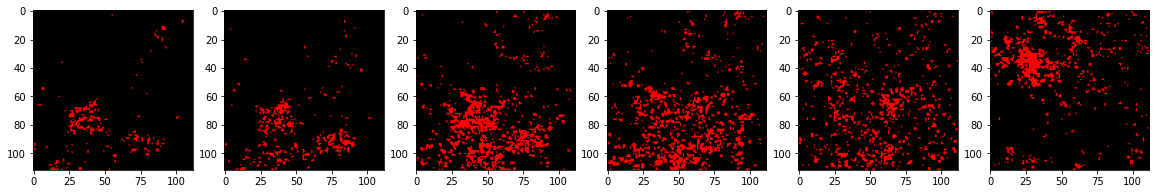

In [ ]:
## plotting example time series images at 6 consecutive timesteps (months)
plt.rcParams["figure.figsize"] = (20,4)
f, ax = plt.subplots(ncols=6, nrows=1)
for k in range(6):
  ax[k].imshow(fire_monthly[k])

In [ ]:
## normalized difference vegetation index (take change between images which is easier to detect)

ndvi_image_ts = [ndvi_image[i][1:] for i in range(len(ndvi_image))]
ndvi_image_ts = [[ndvi_image_ts[i][x] 
                  for x in sorted([x for x in range(0, len(ndvi_image_ts[i]), 2)] + [7,55,99,147,191,239])] 
                  for i in range(len(ndvi_image_ts))]
ndvi_image = [[ndvi_image[i][0]] + ndvi_image_ts[i] for i in range(len(ndvi_image))]

for g in range(len(ndvi_image)):
    ndvi_change = list()
    for i in range(1, len(ndvi_image[g])): 
        ## current image
        cv_ndvi = cv2.imread(ndvi_image[g][i], -1)
        cv_ndvi_resize = cv2.resize(cv_ndvi, (1120,1120), interpolation = cv2.INTER_AREA)
        ## previous image
        cv_ndvi_prior = cv2.imread(ndvi_image[g][i-1], -1)
        cv_ndvi_prior_resize = cv2.resize(cv_ndvi_prior, (1120,1120), interpolation = cv2.INTER_AREA)
        ## difference between t and t - 1
        cv_ndvi_change =  cv_ndvi_resize - cv_ndvi_prior_resize
        ndvi_change.append(cv_ndvi_change)

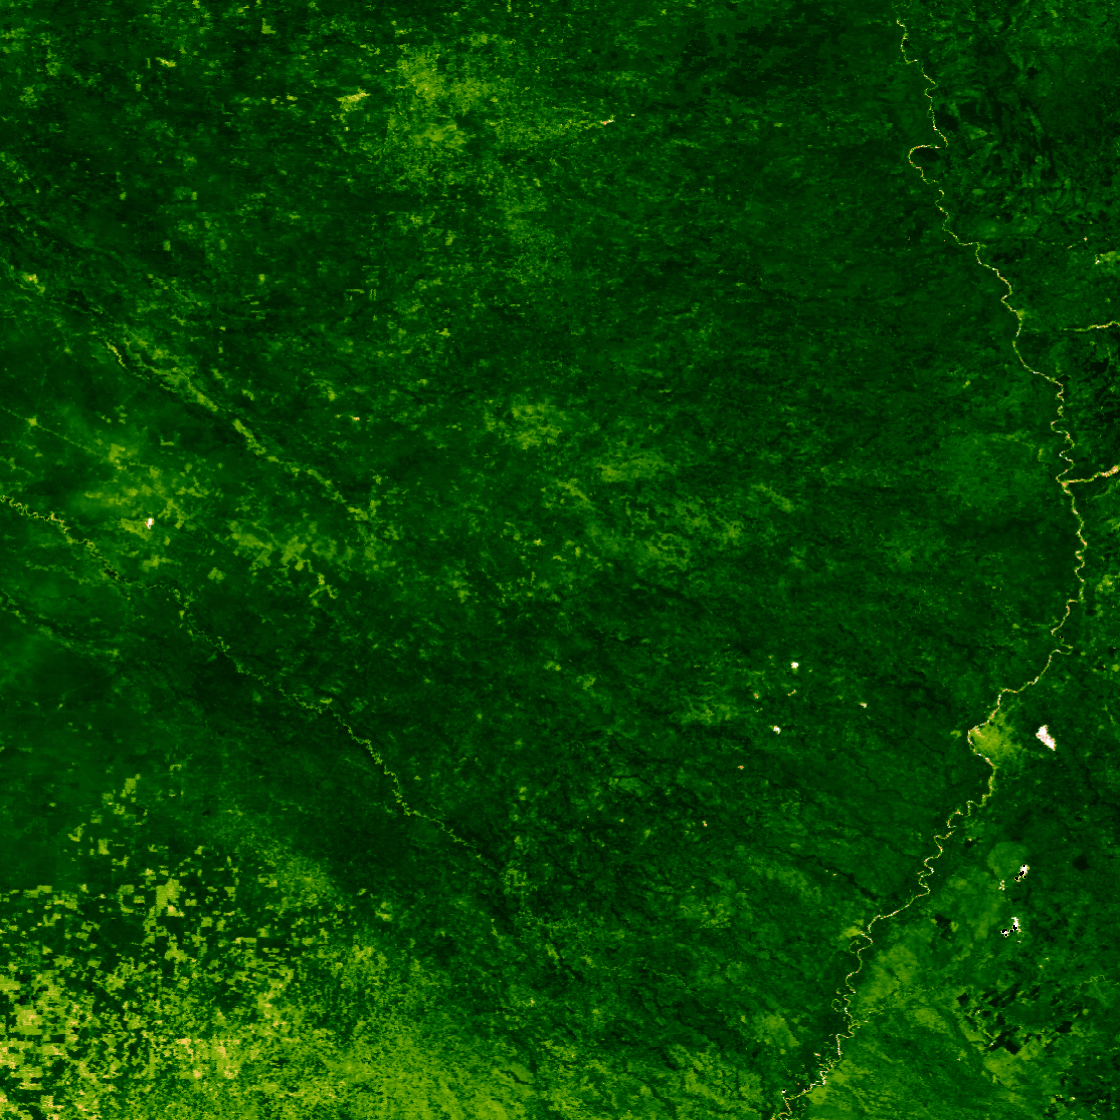

In [ ]:
## example image of NDVI image at time t
cv2_imshow(cv_ndvi_resize)

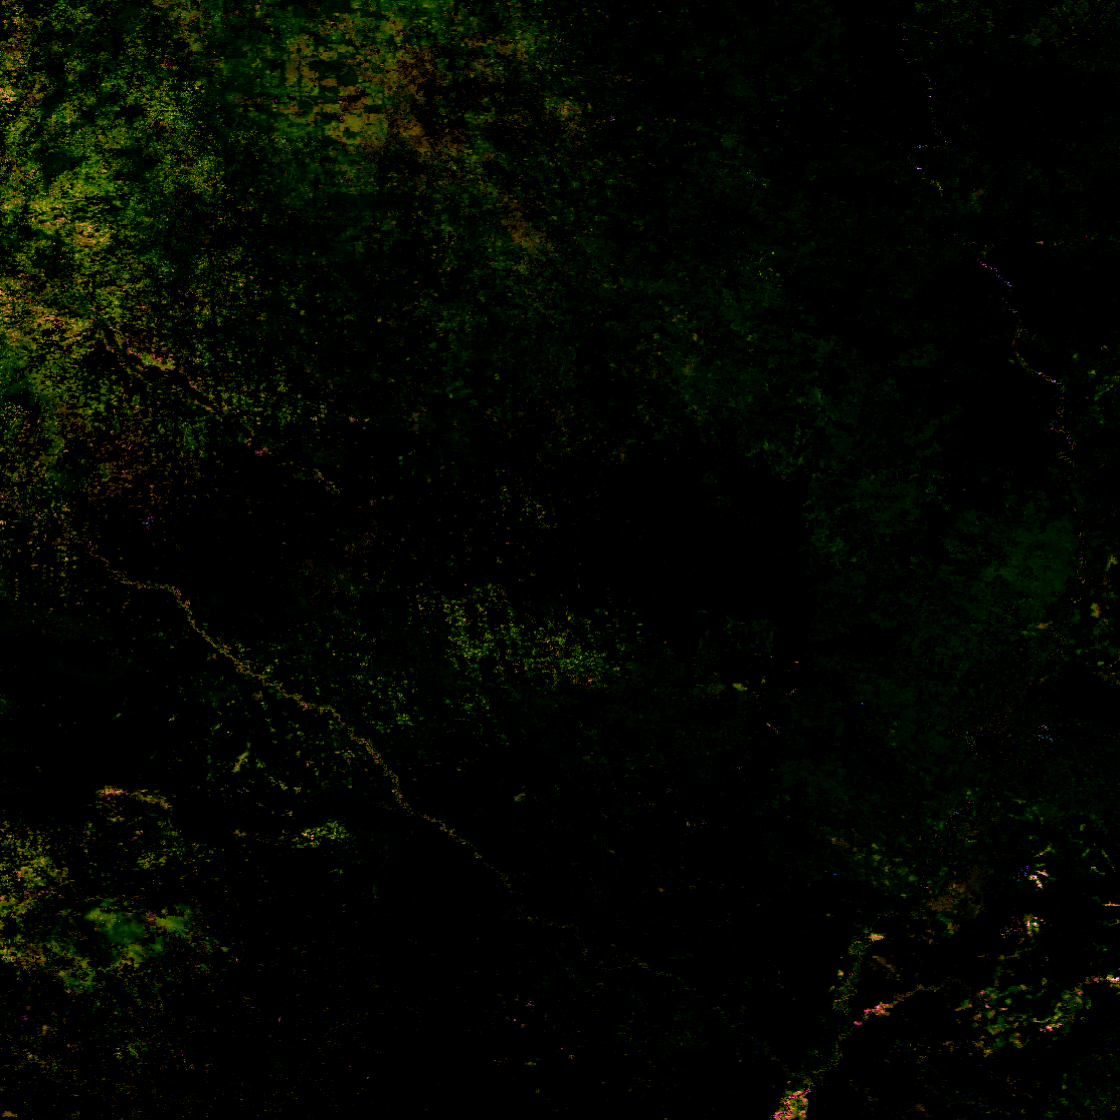

In [ ]:
## example image of NDVI changes between time t and time t - 1
cv2_imshow(cv_ndvi_prior_resize - cv_ndvi_resize)

In [ ]:
## Land Cover class gradients
LC = []
for n in range(len(land_cover_image)):
    LC_img = []
    for m in range(len(land_cover_image[n])):
        cv_LC = cv2.imread(land_cover_image[n][m], -1)
        cv_LC_resize = cv2.resize(cv_LC, (1120,1120), interpolation = cv2.INTER_AREA)
        cv_LC_resize = np.nan_to_num(cv_LC_resize, nan=0)
        LC_img.append(cv_LC_resize)
    LC.append(LC_img)

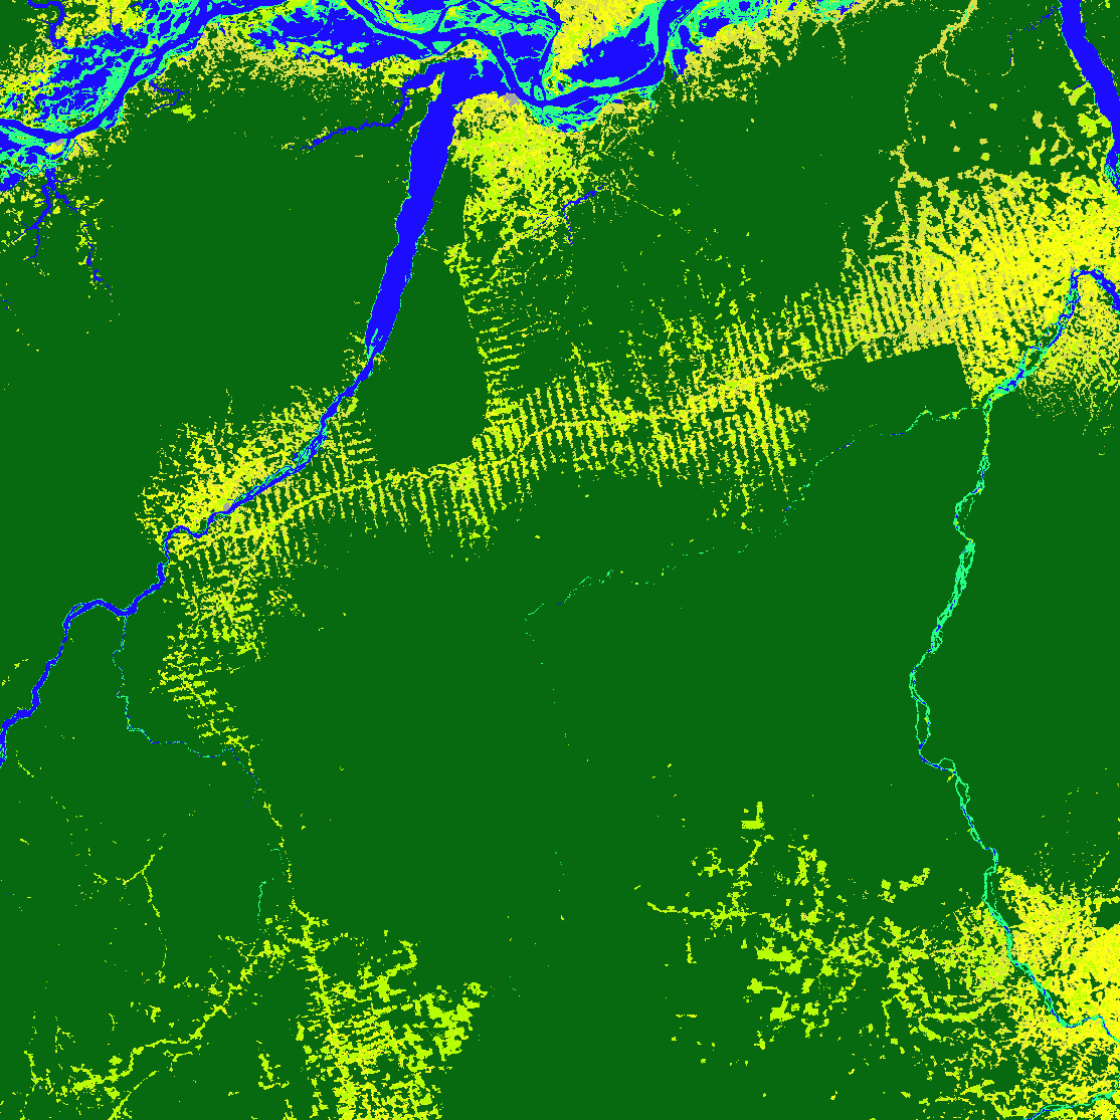

In [ ]:
## example image of land covers
cv2_imshow(cv_LC_resize)

In [ ]:
## Elevation image
elevation = []
for e in range(len(elevation_image)):
    cv_elev = cv2.imread(elevation_image[e], -1)
    cv_elev_resize = cv2.resize(cv_elev, (280,280), interpolation = cv2.INTER_AREA)
    cv_elev_resize = np.nan_to_num(cv_elev_resize, nan=0)
    elevation.append(cv_elev_resize)

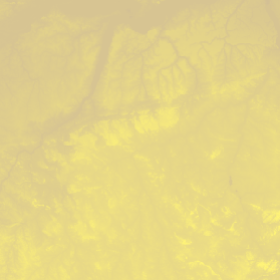

In [ ]:
## example image of elevation image
cv2_imshow(cv_elev_resize)

In [ ]:
## Weather features
## 4) ERA5 weather features
## 5) ERA5 Land condition features
## 6) MODIS aerosol features

## paths
amz_aod_path = ""
amz_era5_monthly_path = ""
amz_era5_daily_path = ""
amz_era5_land_monthly_path = ""
amz_era5_land_daily_path = ""

## file lists
amz_aod_csv = [f for f in os.listdir(amz_aod_path)]
amz_era5_monthly_csv = [f for f in os.listdir(amz_era5_monthly_path)]
amz_era5_daily_csv = [f for f in os.listdir(amz_era5_daily_path)]
amz_era5_land_monthly_sub = [f for f in os.listdir(amz_era5_land_monthly_path)]
amz_era5_land_daily_sub = [f for f in os.listdir(amz_era5_land_daily_path)]
amz_era5_land_monthly_csv = [[f for f in os.listdir(amz_era5_land_monthly_path + s + '/')] for s in [f for f in os.listdir(amz_era5_land_monthly_path)]]
amz_era5_land_daily_csv = [[f for f in os.listdir(amz_era5_land_daily_path + s + '/')] for s in [f for f in os.listdir(amz_era5_land_daily_path)]]

## grid label and filename strings
string_for_query_aod = ["_".join([str(x) for x in amz_atmosphere_grid[y]]) for y in range(len(amz_atmosphere_grid))]
string_for_query_era5_monthly = [amz_weather_grid_label[y] for y in range(len(amz_weather_grid_label))]
string_for_query_era5_daily = [amz_weather_grid_label[y] for y in range(len(amz_weather_grid_label))]
string_for_query_era5_land_monthly = [amz_weather_land_grid_label[y] for y in range(len(amz_weather_land_grid_label))]
string_for_query_era5_land_daily = [amz_weather_land_grid_label[y] for y in range(len(amz_weather_land_grid_label))]

## map the file to grids
amz_aod_csv_rearrange = [x for q in range(len(string_for_query_aod)) 
                           for x in amz_aod_csv 
                           if string_for_query_aod[q] in x]
amz_era5_monthly_csv_rearrange = [x for q in range(len(string_for_query_era5_monthly)) 
                                    for x in amz_era5_monthly_csv 
                                    if string_for_query_era5_monthly[q] in x]
amz_era5_daily_csv_rearrange = [x for q in range(len(string_for_query_era5_daily)) 
                                  for x in amz_era5_daily_csv 
                                  if string_for_query_era5_daily[q] in x]
amz_era5_land_monthly_csv_rearrange = [y for q in range(len(string_for_query_era5_land_monthly)) 
                                         for x in amz_era5_land_monthly_csv for y in x 
                                         if string_for_query_era5_land_monthly[q] in y]
amz_era5_land_daily_csv_rearrange = [y for q in range(len(string_for_query_era5_land_daily)) 
                                       for x in amz_era5_land_daily_csv for y in x 
                                       if string_for_query_era5_land_daily[q] in y]                                         

In [ ]:
## Aerosol features:  extraction
records = list()
for i in range(len(amz_aod_csv_rearrange)):
    temp_path = amz_aod_path + amz_aod_csv_rearrange[i]
    temp_csv = pd.read_csv(temp_path)
    temp_csv = temp_csv.iloc[1:,:]
    temp_csv['time'] = temp_csv['time'].apply(lambda x: datetime.fromtimestamp(int(float(x))/1000))
    temp_csv = temp_csv.sort_values('time')
    temp_arr = np.array(temp_csv.iloc[:,-4:].astype('float'))
    records.append(temp_arr)

aerosol_bands = list()
for t in range(len(sorted(list(set(temp_csv['time']))))):
    aerosol_bands_one_step = np.zeros((40,50,4))
    iter = 0
    for j in range(50):
        for i in range(40):
            aerosol_bands_one_step[40-1-i,j,:] = records[iter][t,:]
            iter += 1
    aerosol_bands.append(aerosol_bands_one_step)

In [ ]:
## Aerosol features:  example dataframe
temp_csv

id  ... Cloud_Optical_Thickness_Liquid_Log_Std_Deviation_Mean
1   A2017001  ...                                               2344   
2   A2017032  ...                                               2326   
3   A2017060  ...                                               2338   
4   A2017091  ...                                               2347   
5   A2017121  ...                                               2376   
6   A2017152  ...                                               2325   
7   A2017182  ...                                               2347   
8   A2017213  ...                                               2299   
9   A2017244  ...                                               2318   
10  A2017274  ...                                               2295   
11  A2017305  ...                                               2355   
12  A2017335  ...                                               2363   
13  A2018001  ...                                               2351   
14  A2018032  ...                                               2285   
15  A2018060  ...                                               2336   
16  A2018091  ...                                               2348   
17  A2018121  ...                                               2337   
18  A2018152  ...                                               2314   
19  A2018182  ...                                               2291   
20  A2018213  ...                                               2279   
21  A2018244  ...                                               2323   
22  A2018274  ...                                               2332   
23  A2018305  ...                                               2352   
24  A2018335  ...                                               2373   
25  A2019001  ...                                               2358   
26  A2019032  ...                                               2292   
27  A2019060  ...                                               2311   
28  A2019091  ...                                               2321   
29  A2019121  ...                                               2362   
30  A2019152  ...                                               2324   
31  A2019182  ...                                               2317   
32  A2019213  ...                                               2269   
33  A2019244  ...                                               2310   
34  A2019274  ...                                               2318   
35  A2019305  ...                                               2359   
36  A2019335  ...                                               2370   
37  A2020001  ...                                               2354   
38  A2020032  ...                                               2287   
39  A2020061  ...                                               2328   
40  A2020122  ...                                               2374   
41  A2020153  ...                                               2330   
42  A2020183  ...                                               2322   
43  A2020214  ...                                               2293   
44  A2020245  ...                                               2318   
45  A2020275  ...                                               2364   
46  A2020306  ...                                               2350   
47  A2020336  ...                                               2380   
48  A2021001  ...                                               2330   
49  A2021032  ...                                               2339   
50  A2021060  ...                                               2349   
51  A2021121  ...                                               2294   
52  A2021152  ...                                               2337   

[52 rows x 8 columns]

In [ ]:
## ERA5 weather features (Monthly):  extraction
## ERA5 weather features (Daily):  extraction

def era5_weather_extract_func(csv_path, csv_name, window_width, window_height):
    records = list()

    for i in range(len(csv_name)):

        temp_path = csv_path + csv_name[i]
        temp_csv = pd.read_csv(temp_path)
        temp_csv = temp_csv.iloc[1:,:]
        temp_csv['time'] = temp_csv['time'].apply(lambda x: datetime.fromtimestamp(int(float(x))/1000))

        iter = 0
        local_list = []

        for t in range(len(sorted(list(set(temp_csv['time']))))):

            grid_list = {}
            local_arr_temperature = np.zeros((4,4,4))
            local_arr_precipitation = np.zeros((4,4,1))
            local_arr_pressure = np.zeros((4,4,2))
            local_arr_wind = np.zeros((4,4,2))

            for px in range(4):
                for py in range(4):

                    local_arr_temperature[4-1-px, py] = np.array(temp_csv.iloc[iter,4:8]).astype('float')
                    local_arr_precipitation[4-1-px, py] = np.array(temp_csv.iloc[iter,8]).astype('float')
                    local_arr_pressure[4-1-px, py] = np.array(temp_csv.iloc[iter,9:11]).astype('float')
                    local_arr_wind[4-1-px, py] = np.array(temp_csv.iloc[iter,11:13]).astype('float')
                    iter += 1

            grid_list['temperature'] = local_arr_temperature
            grid_list['precipitation'] = local_arr_precipitation
            grid_list['pressure'] = local_arr_pressure
            grid_list['wind'] = local_arr_wind

            local_list.append(grid_list)

        records.append(local_list)

    ts_bands = {}
    ts_bands['temperature'] = []
    ts_bands['precipitation'] = []
    ts_bands['pressure'] = []
    ts_bands['wind'] = []

    for t in range(len(sorted(list(set(temp_csv['time']))))):

        global_arr_temperature = np.zeros((window_height*4,window_width*4,4))
        global_arr_precipitation = np.zeros((window_height*4,window_width*4,1))
        global_arr_pressure = np.zeros((window_height*4,window_width*4,2))
        global_arr_wind = np.zeros((window_height*4,window_width*4,2))

        iter = 0

        for j in range(0, window_width*4, 10):
            for i in range(0, window_height*4, 10):
                global_arr_temperature[window_height*4-(i+4):(window_height*4-i),j:(j+4),:] = records[iter][t]['temperature']
                global_arr_precipitation[window_height*4-(i+4):(window_height*4-i),j:(j+4),:] = records[iter][t]['precipitation']
                global_arr_pressure[window_height*4-(i+4):(window_height*4-i),j:(j+4),:] = records[iter][t]['pressure']
                global_arr_wind[window_height*4-(i+4):(window_height*4-i),j:(j+4),:] = records[iter][t]['wind']
                iter += 1

        ts_bands['temperature'].append(global_arr_temperature)
        ts_bands['precipitation'].append(global_arr_precipitation)
        ts_bands['pressure'].append(global_arr_pressure)
        ts_bands['wind'].append(global_arr_wind)
      
    return ts_bands

In [ ]:
## monthly & daily extract
era5_monthly_bands = era5_weather_extract_func(amz_era5_monthly_path, amz_era5_monthly_csv_rearrange, 50, 40)
era5_daily_bands = era5_weather_extract_func(amz_era5_daily_path, amz_era5_daily_csv_rearrange, 50, 40)

In [ ]:
## ERA5 weather features (Monthly) features:  example dataframe
temp_csv

id           longitude  ... u_component_of_wind_10m v_component_of_wind_10m
1    201701  -81.87582367696864  ...       2.852393627166748      1.0981239080429077
2    201702  -81.87582367696864  ...       2.972012996673584       1.697789192199707
3    201703  -81.87582367696864  ...       2.139000415802002       4.025296688079834
4    201704  -81.87582367696864  ...       2.054292917251587       2.235057830810547
5    201705  -81.87582367696864  ...      3.5597586631774902       0.457048237323761
..      ...                 ...  ...                     ...                     ...
668  202002  -81.12573041472884  ...      0.5157821774482727       4.911380290985107
669  202003  -81.12573041472884  ...      1.2014796733856201     0.28358161449432373
670  202004  -81.12573041472884  ...      2.3749847412109375    0.010510931722819805
671  202005  -81.12573041472884  ...      3.2793328762054443      1.4662389755249023
672  202006  -81.12573041472884  ...        6.86614465713501    0.008379236795008183

[672 rows x 13 columns]

In [ ]:
## ERA5-Land weather features (Monthly):  extraction
## ERA5-Land weather features (Daily):  extraction

def era5_land_extract_func(csv_path, csv_subpath, csv_name, grids, grid_dim, frequency="monthly", hourly_data_aggregation=None, num_fire_seasons=None):

    if frequency not in ['monthly', 'hourly']:
        raise ValueError("Data frequency must be either 'monthly' or 'hourly'.")
    else:

        records = list()
        count = 0

        for k in range(len(csv_subpath)):

            sublist = []

            if frequency == "monthly":
                stop_criteria = count + grid_dim ** 2
            elif frequency == "hourly":
                stop_criteria = count + num_fire_seasons * grid_dim ** 2

            i = count
            while i < stop_criteria:

                temp_path = csv_path + csv_subpath[k] + '/' + csv_name[i]
                temp_csv = pd.read_csv(temp_path)
                temp_csv = temp_csv.iloc[1:,:]

                if frequency == "monthly":
                    temp_csv['time'] = temp_csv['time'].apply(lambda x: datetime.fromtimestamp(int(float(x))/1000))
                elif frequency == "hourly":
                    temp_csv['time'] = temp_csv['time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
                    if hourly_data_aggregation == "mean":
                        temp_csv = temp_csv.groupby(['time']).mean()
                    elif hourly_data_aggregation == "max":
                        temp_csv = temp_csv.groupby(['time']).max()
                    elif hourly_data_aggregation == "min":
                        temp_csv = temp_csv.groupby(['time']).min()
                    elif hourly_data_aggregation == "sum":
                        temp_csv = temp_csv.groupby(['time']).sum()
                    elif hourly_data_aggregation == "median":
                        temp_csv = temp_csv.groupby(['time']).median()
                    else:
                        raise ValueError("Aggregation must be in ('mean','max','min','median','sum')")
                    temp_csv = temp_csv.reset_index()

                iter = 0
                local_list = []

                for t in range(len(sorted(list(set(temp_csv['time']))))):

                    grid_list = {}
                    local_arr_temperature = np.zeros((10,10,2))
                    local_arr_pressure = np.zeros((10,10,1))
                    local_arr_precipitation = np.zeros((10,10,1))
                    local_arr_wind = np.zeros((10,10,2))
                    local_arr_soil_temperature = np.zeros((10,10,5))
                    local_arr_soil_water = np.zeros((10,10,5))
                    local_arr_lake = np.zeros((10,10,7))
                    local_arr_snow = np.zeros((10,10,8))
                    local_arr_albedo = np.zeros((10,10,1))
                    local_arr_radiation = np.zeros((10,10,6))
                    local_arr_evaporation = np.zeros((10,10,7))
                    local_arr_runoff = np.zeros((10,10,3))
                    local_arr_leaf = np.zeros((10,10,2))

                    for px in range(10):
                        for py in range(10):

                            local_arr_temperature[10-1-px, py] = np.array(temp_csv.iloc[iter,4:6]).astype('float')
                            local_arr_pressure[10-1-px, py] = np.array(temp_csv.iloc[iter,8]).astype('float')
                            local_arr_precipitation[10-1-px, py] = np.array(temp_csv.iloc[iter,9]).astype('float')
                            local_arr_wind[10-1-px, py] = np.array(temp_csv.iloc[iter,6:8]).astype('float')
                            local_arr_soil_temperature[10-1-px, py] = np.array(temp_csv.iloc[iter,10:15]).astype('float')
                            local_arr_soil_water[10-1-px, py] = np.array(temp_csv.iloc[iter,15:20]).astype('float')
                            local_arr_lake[10-1-px, py] = np.array(temp_csv.iloc[iter,20:27]).astype('float')
                            local_arr_snow[10-1-px, py] = np.array(temp_csv.iloc[iter,27:35]).astype('float')
                            local_arr_albedo[10-1-px, py] = np.array(temp_csv.iloc[iter,35]).astype('float')
                            local_arr_radiation[10-1-px, py] = np.array(temp_csv.iloc[iter,36:42]).astype('float')
                            local_arr_evaporation[10-1-px, py] = np.array(temp_csv.iloc[iter,42:49]).astype('float')
                            local_arr_runoff[10-1-px, py] = np.array(temp_csv.iloc[iter,49:52]).astype('float')
                            local_arr_leaf[10-1-px, py] = np.array(temp_csv.iloc[iter,52:54]).astype('float')
                            iter += 1

                    grid_list['temperature'] = local_arr_temperature
                    grid_list['precipitation'] = local_arr_precipitation
                    grid_list['pressure'] = local_arr_pressure
                    grid_list['wind'] = local_arr_wind
                    grid_list['soil_temperature'] = local_arr_soil_temperature
                    grid_list['soil_water'] = local_arr_soil_water
                    grid_list['lake'] = local_arr_lake
                    grid_list['snow'] = local_arr_snow
                    grid_list['albedo'] = local_arr_albedo
                    grid_list['radiation'] = local_arr_radiation
                    grid_list['evaporation'] = local_arr_evaporation
                    grid_list['runoff'] = local_arr_runoff
                    grid_list['leaf'] = local_arr_leaf

                    local_list.append(grid_list)

                sublist.append(local_list)

            if frequency == "monthly":
                count += grid_dim ** 2
            elif frequency == "hourly":
                count += num_fire_seasons * grid_dim ** 2

            records.append(sublist)

        bands = []
        for g in range(len(grids)):

            ts_bands = {}
            ts_bands['temperature'] = []
            ts_bands['precipitation'] = []
            ts_bands['pressure'] = []
            ts_bands['wind'] = []
            ts_bands['soil_temperature'] = []
            ts_bands['soil_water'] = []
            ts_bands['lake'] = []
            ts_bands['snow'] = []
            ts_bands['albedo'] = []
            ts_bands['radiation'] = []
            ts_bands['evaporation'] = []
            ts_bands['runoff'] = []
            ts_bands['leaf'] = []

            for t in range(len(sorted(list(set(temp_csv['time']))))):
                global_arr_temperature = np.zeros((grid_dim*10,grid_dim*10,2))
                global_arr_precipitation = np.zeros((grid_dim*10,grid_dim*10,1))
                global_arr_pressure = np.zeros((grid_dim*10,grid_dim*10,1))
                global_arr_wind = np.zeros((grid_dim*10,grid_dim*10,2))
                global_arr_soil_temperature = np.zeros((grid_dim*10,grid_dim*10,5))
                global_arr_soil_water = np.zeros((grid_dim*10,grid_dim*10,5))
                global_arr_lake = np.zeros((grid_dim*10,grid_dim*10,7))
                global_arr_snow = np.zeros((grid_dim*10,grid_dim*10,8))
                global_arr_albedo = np.zeros((grid_dim*10,grid_dim*10,1))
                global_arr_radiation = np.zeros((grid_dim*10,grid_dim*10,6))
                global_arr_evaporation = np.zeros((grid_dim*10,grid_dim*10,7))
                global_arr_runoff = np.zeros((grid_dim*10,grid_dim*10,3))
                global_arr_leaf = np.zeros((grid_dim*10,grid_dim*10,2))

                iter = 0
                for j in range(0, 5*10, 10):
                    for i in range(0, 5*10, 10):
                        global_arr_temperature[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['temperature']
                        global_arr_precipitation[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['precipitation']
                        global_arr_pressure[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['pressure']
                        global_arr_wind[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['wind']
                        global_arr_soil_temperature[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['soil_temperature']
                        global_arr_soil_water[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['soil_water']
                        global_arr_lake[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['lake']
                        global_arr_snow[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['snow']
                        global_arr_albedo[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['albedo']
                        global_arr_radiation[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['radiation']
                        global_arr_evaporation[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['evaporation']
                        global_arr_runoff[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['runoff']
                        global_arr_leaf[grid_dim*10-(i+10):(grid_dim*10-i),j:(j+10),:] = records[g][iter][t]['leaf']
                        iter += 1

                ts_bands['temperature'].append(global_arr_temperature)
                ts_bands['precipitation'].append(global_arr_precipitation)
                ts_bands['pressure'].append(global_arr_pressure)
                ts_bands['wind'].append(global_arr_wind)
                ts_bands['soil_temperature'].append(global_arr_soil_temperature)
                ts_bands['soil_water'].append(global_arr_soil_water)
                ts_bands['lake'].append(global_arr_lake)
                ts_bands['snow'].append(global_arr_snow)
                ts_bands['albedo'].append(global_arr_albedo)
                ts_bands['radiation'].append(global_arr_radiation)
                ts_bands['evaporation'].append(global_arr_evaporation)
                ts_bands['runoff'].append(global_arr_runoff)
                ts_bands['leaf'].append(global_arr_leaf)

            bands.append(ts_bands)

    return bands

In [ ]:
## monthly & daily extract
era5_land_monthly_bands = era5_land_extract_func(amz_era5_land_monthly_path, 
                                                 amz_era5_land_monthly_sub, 
                                                 amz_era5_land_monthly_csv_rearrange, 
                                                 amz_points_boundary, 5)
## prepare 3 sets of aggregated daily data:  mena, max and min (extremes)
era5_land_daily_bands_mean = era5_land_extract_func(amz_era5_land_daily_path, 
                                                    amz_era5_land_daily_sub, 
                                                    amz_era5_land_daily_csv_rearrange, 
                                                    amz_points_boundary, 5, "hourly", "mean", 3)
era5_land_daily_bands_max = era5_land_extract_func(amz_era5_land_daily_path, 
                                                   amz_era5_land_daily_sub, 
                                                   amz_era5_land_daily_csv_rearrange, 
                                                   amz_points_boundary, 5, "hourly", "max", 3)
era5_land_daily_bands_min = era5_land_extract_func(amz_era5_land_daily_path, 
                                                   amz_era5_land_daily_sub, 
                                                   amz_era5_land_daily_csv_rearrange, 
                                                   amz_points_boundary, 5, "hourly", "min", 3)
era5_land_daily_bands_sum = era5_land_extract_func(amz_era5_land_daily_path, 
                                                   amz_era5_land_daily_sub, 
                                                   amz_era5_land_daily_csv_rearrange, 
                                                   amz_points_boundary, 5, "hourly", "sum", 3)

In [ ]:
## ERA5-Land weather features (Daily):  example dataframe
temp_csv

time  ...  leaf_area_index_low_vegetation
0    2018-06-01  ...                        1.630971
1    2018-06-02  ...                        1.624395
2    2018-06-03  ...                        1.617811
3    2018-06-04  ...                        1.611230
4    2018-06-05  ...                        1.604640
..          ...  ...                             ...
544  2020-11-26  ...                        1.971175
545  2020-11-27  ...                        1.978121
546  2020-11-28  ...                        1.985082
547  2020-11-29  ...                        1.992043
548  2020-11-30  ...                        1.999006

[549 rows x 43 columns]

#### 3) Data feature engineering:

Several tasks of feature engineering were required before the inputs could be fed into the major deep learning model with Bi-directional ConvLSTM and self-attention. <br>
<ul>
<li>First, for concatenation of features, the image size and the spatially reduced per-grid dimension of the ERA5 weather and land condition features must be aligned at some point, there are generally two ways to extract a compressed image dimension, 1) using a convolutional (variational) autoencoder (C-VAE); 2) adding convolution layers (Conv3D) to the image feature input channels before passing to the BiConvLSTM layers constituting the encoder. Since for wildfire and NDVI images, spatiotemporal concatenations of features were needed for creating time lags and dependence with neighboring grids in this experiment, the prior method (i.e., pre-compression) was chosen. </li>
<li>Second, similarly, for aligning the occurred frequnecy of MODIS aerosol features to that of ERA5 features in daily prediction, the monthly aerosol series were interpolated to daily range with a spline of order of two.</li>
<li>Third, time lags and neighbouring grid context vectors were created through concatenation operations. In this project, the time lags used for daily prediction was 8 days and that for monthly prediction was 6 months, while the spatial context vectors considered features of the 5 relevant grids (the local grid an grids at the east, south, west and north of the local grid). </li>
<li>Fourth, logarithm and power transformation of severely-skewed weather and land condition features might be required.</li>
<li>Fifth, all features were min-max scaled.</li>
</ul>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import gc

In [ ]:
## example of Conv-VAE applied on original image width and height of 1120 x 1120 pixels, reduced to 50 x 50 pixels

class ConvVAE_1120(tf.keras.Model):
    """Convolutional variational autoencoder"""
    """for burned area (long term), ndvi & change images, land cover & change images"""

    def __init__(self, width, height, depth, reduced_width, reduced_height, latent_dim):
        super(ConvVAE_1120, self).__init__()
        self.width = int(width)
        self.height = int(height)
        self.reduced_width = int(reduced_width)
        self.reduced_height = int(reduced_height)
        self.depth = int(depth)
        self.latent_dim = int(latent_dim)

        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    class Sampling(tf.keras.layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_encoder(self):
        encoder_inputs = tf.keras.Input(shape=(self.width, self.height, self.depth))
        x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(5,5))(x)
        x = tf.keras.layers.Conv2D(16, 2, activation="relu", strides=3, padding="same")(x)
        x = tf.keras.layers.Conv2D(8, 2, activation="relu", strides=1, padding="same")(x)
        x = tf.keras.layers.Conv2D(4, 2, activation="relu", strides=1, padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.latent_dim, activation="relu")(x)
        z_mean = tf.keras.layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = tf.keras.layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = self.Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
    
    def get_decoder(self):
        latent_inputs = tf.keras.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense((self.reduced_width // 2) * (self.reduced_height // 2) * 8, activation="relu")(latent_inputs)
        x = tf.keras.layers.Reshape((self.reduced_width // 2, self.reduced_height // 2, 8))(x)
        x = tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
        x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(3,3))(x)
        x = tf.keras.layers.Conv2DTranspose(32, 3, strides=5, padding="same")(x)
        x = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same")(x)
        x = tf.keras.layers.Conv2DTranspose(8, 3, strides=2, padding="same")(x)
        decoder_outputs = tf.keras.layers.Conv2DTranspose(self.depth, 1, strides=1, activation="sigmoid", padding="same")(x)
        decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            reconstruction_loss = reconstruction_loss / (data.shape[0] * data.shape[1])
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
burnedArea_CVAE = ConvVAE_1120(width=1120, height=1120, depth=3, reduced_width=50, reduced_height=50, latent_dim=50*50*2)
burnedArea_CVAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
burnedArea_CVAE.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1120, 1120,  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 560, 560, 128 3584        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 280, 280, 64) 73792       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 140, 140, 32) 18464       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [ ]:
burnedArea_CVAE.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5000)]            0         
_________________________________________________________________
dense_9 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
reshape_4 (Reshape)          (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 25, 25, 32)        2336      
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 50, 50, 32)        9248      
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 280, 280, 32)      9248

In [ ]:
for n in range(len(monthly_burned_area_image)):
    with open(monthly_burned_area_path + monthly_burned_area_image[n], "rb") as f:
        train_x = pickle.load(f)
    train_x = np.array([x for x in train_x])
    train_x = train_x / 255.0
    burnedArea_CVAE.fit(train_x, epochs=5, batch_size=3)
    del train_x
    gc.collect()
    print("\n")

In [ ]:
ndvi_CVAE = ConvVAE_1120(width=1120, height=1120, depth=3, reduced_width=50, reduced_height=50, latent_dim=50*50*2)
ndvi_CVAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
for n in range(len(ndvi_change)):
    train_x = np.array([x for x in ndvi_change[n]])
    train_x = np.nan_to_num(train_x, nan=0)
    train_x = train_x / 255.0
    ndvi_CVAE.fit(train_x, epochs=5, batch_size=3)
    del train_x
    gc.collect()
    print("\n")

In [ ]:
## function to get intermediate outputs
def get_CVAE_embeddings(model, layer_name, inputs, inputs_folder):

    cvae_vectors = []
    intermediate = tf.keras.Model(inputs = model.decoder.input, 
                                  outputs = model.decoder.get_layer(layer_name).output)
    for g in range(len(inputs)):
        with open(inputs_folder + inputs[g], "rb") as f:
            train_x = pickle.load(f)
        train_x = np.array([x for x in train_x])
        train_x = np.nan_to_num(train_x, nan=0)
        train_x = train_x / 255.0
        encoded_x = model.encoder.predict(train_x, batch_size=3)
        latent = intermediate.predict(encoded_x[2], batch_size=3)
        
        del train_x
        del encoded_x
        del latent
        gc.collect()

        cvae_vectors.append(latent)
        return cvae_vectors

## example
burned_area_cvae_outputs = get_CVAE_embeddings(burnedArea_CVAE, "conv2d_transpose_1", monthly_burned_area_image, monthly_burned_area_path)
ndvi_cvae_outputs = get_CVAE_embeddings(ndvi_CVAE, "conv2d_transpose_1", ndvi_change, ndvi_path)

In [ ]:
## spline interpolation of aerosol features with order = 2

aerosol_interp = list()
timestamps = sorted(list(set(temp_csv['time'])))

## initialization
for t in range(len(timestamps)):
    arr = np.zeros((50, 40, 4))
    aerosol_interp.append(arr)

## populate values
for feature in range(4):
    ## get global median
    global_med = [np.nanmedian(aerosol_bands[t][:,:,feature]) for t in range(len(aerosol_bands))]
    ## reorder observations
    reordered = [[[aerosol_bands[t][i,j,feature] for t in range(len(aerosol_bands))] for j in range(40)] for i in range(50)]
    for i in range(50):
        for j in range(40):
            r = i * j + j
            ## interpolation of time series at a point pixel
            if len(pd.Series(reordered[r])[pd.Series(reordered[r]).isnull()]) == len(pd.Series(reordered[r])):
                interpolated = pd.Series([np.mean(global_med)] * len(timestamps), index = timestamps).\
                                  resample('D').interpolate(method='spline', order=2).values
            else:
                interpolated = pd.Series(reordered[r], index = timestamps).\
                                  fillna(pd.Series(reordered[r], index = timestamps).mode()[0]).\
                                  resample('D').interpolate(method='spline', order=2).values
            for t in range(len(timestamps)):
                aerosol_interp[t][i,j,feature] = interpolated[t]

In [ ]:
## min-max scaling normalization for ERA5 weather and land condition features

def get_global_min_max(feature_list):
    feature_max = np.max(np.concatenate([y.reshape(1, -1) for y in [np.max(x.reshape(x.shape[0] * x.shape[1], -1), axis=0) for x in feature_list]]), axis=0)
    feature_min = np.min(np.concatenate([y.reshape(1, -1) for y in [np.min(x.reshape(x.shape[0] * x.shape[1], -1), axis=0) for x in feature_list]]), axis=0)
    return feature_max, feature_min

def calculate_min_max(feature_list, feature_max, feature_min):
    scaled = [[(y - feature_min) / (feature_max - feature_min) for y in x] for x in feature_list]
    scaled = [[np.nan_to_num(y, nan=np.nanmean(y)) for y in x] for x in feature_list]
    return scaled

## Step 1) Get the global min and max for all features

## Aerosols
max_aerosol, min_aerosol = get_global_min_max(aerosol_interp)

## ERA5 Weather and Land
era5_keys = list(era5_daily_bands[0][0].keys())
land_keys = list(era5_land_daily_bands_mean[0][0].keys())

max_era5_land_mean, min_era5_land_mean = {}, {}
max_era5_land_max, min_era5_land_max = {}, {}
max_era5_land_min, min_era5_land_min = {}, {}
max_era5_land_monthly, min_era5_land_monthly = {}, {}
max_era5_monthly, min_era5_monthly = {}, {}
max_era5_daily, min_era5_daily = {}, {}

for k in land_keys:
    ## daily land
    max_era5_land_mean[k + '_max'], min_era5_land_mean[k + '_min'] = get_global_min_max(era5_land_daily_bands_mean[k])
    max_era5_land_max[k + '_max'], min_era5_land_max[k + '_min'] = get_global_min_max(era5_land_daily_bands_max[k])
    max_era5_land_min[k + '_max'], min_era5_land_min[k + '_min'] = get_global_min_max(era5_land_daily_bands_min[k])
    ## monthly land
    max_era5_land_monthly[k + '_max'], min_era5_land_monthly[k + '_min'] = get_global_min_max(era5_land_monthly_bands[k])

for k in era5_keys:
    ## daily weather
    max_era5_daily[k + '_max'], min_era5_daily[k + '_min'] = get_global_min_max(era5_daily_bands)
    ## monthly weather
    max_era5_monthly[k + '_max'], min_era5_monthly[k + '_min'] = get_global_min_max(era5_monthly_bands)

## Step 2) Apply min-max formula

## Aerosols
aerosol_daily_scaled = [(z - min_aerosol) / (max_aerosol - min_aerosol) for z in aerosol_interp]
aerosol_monthly_scaled = [(z - min_aerosol) / (max_aerosol - min_aerosol) for z in aerosol_bands]

## ERA5 Weather and Land
era5_land_mean_scaled = {}
era5_land_max_scaled = {}
era5_land_min_scaled = {}
era5_land_monthly_scaled = {}
era5_monthly_scaled = {}
era5_daily_scaled = {}

for k in land_keys:
    era5_land_mean_scaled[k] = calculate_min_max(era5_land_daily_bands_mean[k], max_era5_land_mean[k + '_max'], min_era5_land_mean[k + '_min'])
    era5_land_max_scaled[k] = calculate_min_max(era5_land_daily_bands_max[k], max_era5_land_max[k + '_max'], min_era5_land_max[k + '_min'])
    era5_land_min_scaled[k] = calculate_min_max(era5_land_daily_bands_min[k], max_era5_land_min[k + '_max'], min_era5_land_min[k + '_min'])
    era5_land_monthly_scaled[k] = calculate_min_max(era5_land_monthly_bands[k], max_era5_land_monthly[k + '_max'], min_era5_land_monthly[k + '_min'])

for k in era5_keys:
    era5_daily_scaled[k] = calculate_min_max(era5_daily_bands[k], max_era5_daily[k + '_max'], min_era5_daily[k + '_min'])
    era5_monthly_scaled[k] = calculate_min_max(era5_monthly_bands[k], max_era5_monthly[k + '_max'], min_era5_monthly[k + '_min'])

In [ ]:
## logarithm and power transformations of weather and land condition features
## subject to inspection by plotting the variable distributions

## Apply transformations
def feature_transformation_era5_land(feature_dict):

    feature_dict['temperature'] = [np.power(x, 3) for x in feature_dict['temperature']]
    feature_dict['precipitation'] = [np.log(x) for x in feature_dict['precipitation']]
    feature_dict['pressure'] = [np.power(x, 3) for x in feature_dict['pressure']]
    feature_dict['runoff'] = [np.log(x) for x in feature_dict['runoff']]
    feature_dict['soil_temperature'] = [np.power(x, 3) for x in feature_dict['soil_temperature']]
    for x in feature_dict['soil_water']:
        x[:,:,:,0] = np.log(x[:,:,:,0])
    for x in feature_dict['albedo']:
        x[x > 0.3] = 0.3
    for x in range(len(feature_dict['leaf'])):
        leaf_new = np.sum(feature_dict['leaf'][x][:,:,:,:], axis = 3).reshape(-1,50,50,1)
        feature_dict['leaf'][x] = leaf_new
    for x in range(len(feature_dict['evaporation'])):
        feature_dict['evaporation'][x][:,:,:,1] = np.power(feature_dict['evaporation'][x][:,:,:,1], 3)
        feature_dict['evaporation'][x][:,:,:,2] = np.power(feature_dict['evaporation'][x][:,:,:,2], 3)
        feature_dict['evaporation'][x][:,:,:,4] = np.power(feature_dict['evaporation'][x][:,:,:,4], 3)
        feature_dict['evaporation'][x] = feature_dict['evaporation'][x][:,:,:,np.r_[0:3,4,6]]
    
    return feature_dict

def feature_transformation_era5(feature_dict):

    feature_dict['temperature'] = [np.power(x, 3) for x in feature_dict['temperature']]
    feature_dict['precipitation'] = [np.log(x) for x in feature_dict['precipitation']]
    feature_dict['pressure'] = [np.power(x, 3) for x in feature_dict['pressure']]
    
    return feature_dict

#### MAIN ####
era5_land_monthly_scaled = feature_transformation_era5_land(era5_land_monthly_scaled)
era5_land_mean_scaled = feature_transformation_era5_land(era5_land_mean_scaled)
era5_land_max_scaled = feature_transformation_era5_land(era5_land_max_scaled)
era5_land_min_scaled = feature_transformation_era5_land(era5_land_min_scaled)

era5_daily_scaled = feature_transformation_era5(era5_daily_scaled)
era5_monthly_scaled = feature_transformation_era5(era5_monthly_scaled)

In [ ]:
## combine features for grid size
grid_combined_feature_d = [np.concatenate((fire_daily[c], era5_land_mean_scaled[c], era5_land_max_scaled[c], era5_land_min_scaled[c]), axis = 3) 
                          for c in range(20)]
grid_combined_feature_m = [np.concatenate((fire_monthly[c], ndvi_change[c], era5_land_monthly_scaled[c]), axis = 3) 
                          for c in range(20)]

In [ ]:
## Target: 1)  wildfire mask
wf_daily = [np.array([y for y in x]) for x in fire_daily]
wf_monthly = [np.array([y for y in x]) for x in fire_monthly]

## Target: 2)  mean, max, min temperature
y_mean_temp_daily = [np.array([y for y in x]) for x in era5_land_mean_scaled['temperature']]
y_max_temp_daily = [np.array([y for y in x]) for x in era5_land_max_scaled['temperature']]
y_min_temp_daily = [np.array([y for y in x]) for x in era5_land_min_scaled['temperature']]
y_temp_monthly = [np.array([y for y in x]) for x in era5_monthly_scaled['temperature']]

## Target: 3)  sum precipitation, binary precipitation event
prec_sum_daily = era5_land_daily_bands_sum['precipitation']
prec_sum_scaled_daily = [np.array(x) for x in prec_sum_daily]
prec_sum_binary_daily = copy.deepcopy(prec_sum_daily)
for n in range(len(prec_sum_binary_daily)):
    prec_sum_binary_daily[n][prec_sum_binary_daily[n] < 1e-3] = 0
    prec_sum_binary_daily[n][prec_sum_binary_daily[n] >= 1e-3] = 1

prec_sum_monthly = era5_land_monthly_bands['precipitation']
prec_sum_scaled_monthly = [np.array(x) for x in prec_sum_monthly]
prec_sum_binary_monthly = era5_land_monthly_bands['precipitation']
for n in range(len(prec_sum_binary_monthly)):
    prec_sum_binary_monthly[n][prec_sum_binary_monthly[n] < 1e-3] = 0
    prec_sum_binary_monthly[n][prec_sum_binary_monthly[n] >= 1e-3] = 1

In [ ]:
## Concatenation of feature vectors within time lags

def create_time_lag(combined_feature, req_time, lags):
    lag_features = []
    for g in combined_feature:
        grid_lag_feature = []
        for t in req_time:
            arr_window = g[(t-lags):t].reshape(1, lags, g.shape[1], g.shape[2], g.shape[3])
            grid_lag_feature.append(arr_window)
        arr_g = np.concatenate(tuple(grid_lag_feature), axis = 0)
        lag_features.append(arr_g)
    return lag_features

## For daily prediction, Take a lag period to be 8 previous timesteps
## Hence, exclude the first 8 days per the three-year study period
## For monthly prediction, Take a lag period to be 6 previous timesteps
## Hence, exclude the first 6 months per the ten-year study period

req_time_d = [np.arange(8, 183).tolist()] + [np.arange(191, 366).tolist()] + [np.arange(374, 549).tolist()]
req_time_d = [y for x in req_time_d for y in x]
lag_features_d = create_time_lag(grid_combined_feature_d, req_time_d, 8)

req_time_m = [x for x in range(grid_combined_feature_m.shape[0])][6:]
lag_features_m = create_time_lag(grid_combined_feature_m, req_time_m, 6)

In [ ]:
print(lag_features_d[0].shape)
print(lag_features_m[0].shape)

(549, 8, 50, 50, 114)
(133, 8, 50, 50, 114)


In [ ]:
## Concatenation of feature vectors in neighbouring grids in four direction for each central local grid

class SpatialConcat_AmazonForest():
    """"concatenate sub-grids spatially: Spatial Attention"""
    
    def __init__(self, grid_index, features):
        self.grid_index = grid_index
        self.features = features

        ##  matrix method
        self.adjacency_matrix = np.array([
            [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0],
            [0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0],
            [0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0],
            [0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0],
            [0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
            [0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0],
            [0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]
            ])
        
        ##  indexing method
        self.adjacency_indices = [
                     [1,2,-1,-1], [4,3,0,-1], [3,-1,-1,0], [6,12,2,1],
                     [5,6,1,10], [20,7,4,11], [7,13,3,4], [21,16,6,5],
                     [9,10,-1,-1], [-1,11,8,-1], [11,4,-1,8], [-1,5,10,9],
                     [13,14,-1,3], [16,15,12,6], [15,-1,-1,12], [18,-1,14,13],
                     [17,18,13,7], [-1,19,16,21], [19,-1,15,16], [-1,-1,18,17]
        ]
    
    def get_vectors(self, method="matrix"):

        if method == "matrix":

            ## engineer a grid-specific matrix
            spatial_vector = self.adjacency_matrix[self.grid_index]
            spatial_matrix = np.diag(spatial_vector)

            ## matrix mupltiplication, 
            ## if either argument is N-D, N > 2, it is treated as a stack of matrices residing in the last two indexes and broadcast accordingly.
            spa_atten_features = np.matmul(self.features, spatial_matrix)
            
        elif method == "indices":
            
            ## query per each index representing the four directions
            spatial_vector = self.adjacency_indices[self.grid_index]

            spa_atten_features = []
            for g in [self.grid_index] + spatial_vector:
                if g != -1:
                    spa_atten_features.append(self.features[:,:,:,:,:,g].\
                                              reshape(self.features.shape[0], 
                                                      self.features.shape[1], 
                                                      self.features.shape[2], 
                                                      self.features.shape[3], 
                                                      self.features.shape[4], 1))
                else:
                    spa_atten_features.append(np.zeros((self.features.shape[0], 
                                                        self.features.shape[1], 
                                                        self.features.shape[2], 
                                                        self.features.shape[3], 
                                                        self.features.shape[4], 1)))
                    
            spa_atten_features = np.concatenate(tuple(spa_atten_features), axis = 5)

        else:
            raise ValueError("Invalid method specified, choose one of the followings: 'matrix' or 'indices'.")

        return spa_atten_features

In [ ]:
## Demonstrate - matrix multiplication
grid_features = []
for g in range(20):
    concat_features = SpatialConcat_AmazonForest(g, lag_features_d, method = "matrix").get_vectors()
    grid_features.append(concat_features)

In [ ]:
print(grid_features[0].shape)

(549, 8, 50, 50, 114, 20)


In [ ]:
## Demonstrate - indexing encoding
grid_features = []
for g in range(20):
    concat_features = SpatialConcat_AmazonForest(g, lag_features_d, method = "indices").get_vectors()
    grid_features.append(concat_features)

In [ ]:
print(grid_features[0].shape)

(549, 8, 50, 50, 114, 5)


In [ ]:
def reshape_grid_features(array):
    return array.reshape(array.shape[0], array.shape[1], array.shape[2], array.shape[3], array.shape[4] * array.shape[5])
## reshape back to a 5d-array
grid_features = [reshape_grid_features(x) for x in grid_features]

#### 4)  Reasons for spatial reduction / pooling for the target: <br> Rare percentage of pixels of wildfire occurrences (positive class)

Below code blocks present a comparison of the number and percentage of positive class pixels (i.e., actually burned) across all 20 grids, and it could be found that with original resolution of 1120 x 1120 image size, most of the grids generally had an extremely small percentage less than 1%, reducing the resolution by 10 times (112 x 112) or even 20 times (56 x 56), some of the grids had positive pixel percentage increased to over 10%, while a large variation existed among all grids with some of their percentages remained extreme. 

The trade-off between maintaining a high resolution against increasing positive class ratio was however also apparent, with original resolution, the predictions given would be more precise to a confined spatial area, but the extremely imbalanced data would create difficulties for deep learning models to infer an anomalous event; with higher positive class ratio, the performance could be improved but the practical inference of the predictions would be less specific as it spread over a larger region. 

In [ ]:
## specify fire season timesteps
n = 6
fire_season_index = []
while n + 12 < 115:
    for p in range(6):
        fire_season_index.append(n + p)
    n += 12

In [ ]:
## specify timesteps for training models of weather predictions
n = 7
weather_period_index = []
while n < 115:
    for p in range(8):
        weather_period_index.append(n + p)
    n += 12

In [ ]:
## inpsect positive rates for each grid
fire_pixels = []
fire_pixels_percent = []
for n in range(20):
    with open(F'/content/drive/MyDrive/DS project/long_term/burned_area_binary_grid_' + str(n) + '.pkl', 'rb') as f:
        y_wf = pickle.load(f)
    fp = np.count_nonzero(y_wf)
    fpp = fp / (1120*1120*54)
    fire_pixels.append(fp)
    fire_pixels_percent.append(fpp * 100)
fire_pixels_percent = [round(x, 2) for x in fire_pixels_percent]

In [ ]:
print(fire_pixels)
print(fire_pixels_percent)

[563007, 461529, 257474, 155571, 307327, 70266, 374404, 134578, 64905, 11682, 481077, 87703, 138953, 402452, 52671, 166317, 1067180, 114904, 642562, 504342]
[0.83, 0.68, 0.38, 0.23, 0.45, 0.1, 0.55, 0.2, 0.1, 0.02, 0.71, 0.13, 0.21, 0.59, 0.08, 0.25, 1.58, 0.17, 0.95, 0.74]


In [ ]:
## inpsect positive rates for each grid
fire_pixels = []
fire_pixels_percent = []
for n in range(20):
    with open(F'/content/drive/MyDrive/DS project/long_term/burned_area_binary_pooled_grid_' + str(n) + '.pkl', 'rb') as f:
        y_wf = pickle.load(f)
    fp = np.count_nonzero(y_wf[fire_season_index])
    fpp = fp / (112*112*54)
    fire_pixels.append(fp)
    fire_pixels_percent.append(fpp * 100)
fire_pixels_percent = [round(x, 2) for x in fire_pixels_percent]

In [ ]:
print(fire_pixels)
print(fire_pixels_percent)

[33393, 16367, 18694, 9166, 13224, 5399, 16807, 7921, 3494, 1786, 30877, 8338, 17165, 20406, 5201, 10733, 46883, 10078, 35625, 39766]
[4.93, 2.42, 2.76, 1.35, 1.95, 0.8, 2.48, 1.17, 0.52, 0.26, 4.56, 1.23, 2.53, 3.01, 0.77, 1.58, 6.92, 1.49, 5.26, 5.87]


In [ ]:
## inpsect positive rates for each grid
fire_pixels = []
fire_pixels_percent = []
for n in range(20):
    with open(F'/content/drive/MyDrive/DS project/long_term/burned_area_binary_pooled_56dim_grid_' + str(n) + '.pkl', 'rb') as f:
        y_wf = pickle.load(f)
    fp = np.count_nonzero(y_wf[fire_season_index])
    fpp = fp / (56*56*54)
    fire_pixels.append(fp)
    fire_pixels_percent.append(fpp * 100)
fire_pixels_percent = [round(x, 2) for x in fire_pixels_percent]

In [ ]:
print(fire_pixels_percent)

[19359, 9074, 11596, 6014, 7582, 3409, 9724, 5138, 2195, 1280, 17701, 5275, 12461, 12033, 3687, 6726, 24207, 6681, 19983, 23189]
[11.43, 5.36, 6.85, 3.55, 4.48, 2.01, 5.74, 3.03, 1.3, 0.76, 10.45, 3.11, 7.36, 7.11, 2.18, 3.97, 14.29, 3.95, 11.8, 13.69]


In [ ]:
from functools import reduce

In [ ]:
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config = config)

In [ ]:
class BiConvLSTM_Attention_Model_Events(tf.keras.Model):
    """Convolutional LSTM with Attention on previous time/states"""
    
    def __init__(self, mode,
                       img_height, img_width, 
                       output_img_height, output_img_width, 
                       lag_window, neighbour_window,
                       land_grid_height, land_grid_width, land_grid_features,
                       weather_window_height, weather_window_width):
      
        super(BiConvLSTM_Attention_Model_Events, self).__init__()

        self.img_height, self.img_width = img_height, img_width
        self.output_img_height, self.output_img_width = output_img_height, output_img_width
        self.land_grid_height, self.land_grid_width = land_grid_height, land_grid_width
        self.weather_window_height, self.weather_window_width = weather_window_height, weather_window_width
        self.lag_window = lag_window
        self.neighbour_window = neighbour_window
        self.land_grid_features = land_grid_features
        self.mode = mode

        ## parameter check
        if mode not in ["monthly","daily"]:
            raise ValueError("Invalid value, mode should be either 'monthly' or 'daily'.")
        if img_height / 4 < land_grid_height or img_width / 4 < land_grid_width:
            raise ValueError("Image dimension is too small, should be greater than four times of the land grid dimension.")
        if land_grid_height != land_grid_width:
            raise ValueError("Non-square land grid dimension is detected.")

    def find_strides(self, n):
        i = 2
        factors = []
        while i * i <= n:
            if n % i:
                i += 1
            else:
                n //= i
                factors.append(i)
        if n > 1:
            factors.append(n)
        return factors

    def grid_window_alignment_operation(self, x2, x3):

        if self.weather_window_height == self.weather_window_width:

            window_factor = int(self.weather_window_height / self.land_grid_height)
            window_encoders = self.find_strides(window_factor) + [1]

            if self.weather_window_height > self.land_grid_height:
                pad_window_factor = self.land_grid_height - self.weather_window_height % self.land_grid_height
                pad_window_factor = int(pad_window_factor)
            else:
                pad_window_factor = self.land_grid_height - self.weather_window_height
                pad_window_factor = int(pad_window_factor)
            
            if pad_window_factor > 0:
                x2 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_factor), int(0.5 * pad_window_factor)))(x2)
                x3 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_factor), int(0.5 * pad_window_factor)))(x3)

            for w in window_encoders:

                self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(w, w), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
                x2 = self.bi_convlstm_2(x2)
                x2 = tf.keras.layers.BatchNormalization()(x2)

                self.convlstm_3 = tf.keras.layers.ConvLSTM2D(8, kernel_size=(5, 5), strides=(w, w), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_3 = tf.keras.layers.Bidirectional(self.convlstm_3)
                x3 = self.bi_convlstm_3(self.x3)
                x3 = tf.keras.layers.BatchNormalization()(x3)

        elif self.weather_window_height != self.weather_window_width:

            window_factor_height = int(self.weather_window_height / self.land_grid_height)
            window_encoders_height = self.find_strides(window_factor_height) + [1]

            if self.weather_window_height > self.land_grid_height:
                pad_window_height = self.land_grid_height - self.weather_window_height % self.land_grid_height
                pad_window_height = int(pad_window_height)
            else:
                pad_window_height = self.land_grid_height - self.weather_window_height
                pad_window_height = int(pad_window_height)

            window_factor_width = int(self.weather_window_width / self.land_grid_width)
            window_encoders_width = self.find_strides(window_factor_width) + [1]

            if self.weather_window_width > self.land_grid_width:
                pad_window_width = self.land_grid_width - self.weather_window_width % self.land_grid_width
                pad_window_width = int(pad_window_width)
            else:
                pad_window_width = self.land_grid_width - self.weather_window_width
                pad_window_width = int(pad_window_width)

            if pad_window_height > 0 or pad_window_width > 0:
                x2 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_height), int(0.5 * pad_window_width)))(x2)
                x3 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_height), int(0.5 * pad_window_width)))(x3)

            if len(window_encoders_height) > len(window_encoders_width):
                window_encoders_width = window_encoders_width + [1] * (len(window_encoders_height) - len(window_encoders_width))
            elif len(window_encoders_width) > len(window_encoders_height):
                window_encoders_height = window_encoders_height + [1] * (len(window_encoders_width) - len(window_encoders_height))

            window_encoders = [window_encoders_height, window_encoders_width]
            len_window_encoders = len(window_encoders[0])

            for w in range(len_window_encoders):

                self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(window_encoders[0][w], window_encoders[1][w]), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
                self.x2 = self.bi_convlstm_2(self.x2)
                self.convlstm_2 = tf.keras.layers.BatchNormalization()(self.x2)

                self.convlstm_3 = tf.keras.layers.ConvLSTM2D(8, kernel_size=(5, 5), strides=(window_encoders[0][w], window_encoders[1][w]), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_3 = tf.keras.layers.Bidirectional(self.convlstm_3)
                self.x3 = self.bi_convlstm_3(self.x3)
                self.convlstm_3 = tf.keras.layers.BatchNormalization()(self.x3)
        
        return [x2, x3]

    def Deconvolution(self, num_decoder_layers):

        if self.output_img_height > self.land_grid_height and self.output_img_width > self.land_grid_width:

            required_strides = (self.output_img_height - self.output_img_height % self.land_grid_height) // self.land_grid_height
            strides = self.find_strides(required_strides) + [1]
            self.pad_att = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.output_img_height % self.land_grid_height)), 
                                                                  int(0.5 * (self.output_img_width % self.land_grid_width))
                                                                  ))(self.reshape_att)
            if num_decoder_layers > len(strides):
                if num_decoder_layers < 6:
                    start_filter = 128
                else:
                    start_filter = 2 ** num_decoder_layers
            else:
                if len(strides) < 6:
                    start_filter = 128
                else:
                    start_filter = 2 ** len(strides)

            self.deconv = self.pad_att
            for s in strides:
                self.deconv = tf.keras.layers.Conv2DTranspose(filters = start_filter/2, kernel_size=(3, 3), strides = s, padding='same')(self.deconv)
                start_filter = start_filter // 2
            if num_decoder_layers > len(strides):
                for r in range(num_decoder_layers - len(strides)):
                    self.deconv = tf.keras.layers.Conv2DTranspose(filters = start_filter, kernel_size=(3, 3), strides = 1, padding='same')(self.deconv)
            self.outcome = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=1, padding='same')(self.deconv)

        elif self.output_img_height < self.land_grid_height and self.output_img_width < self.land_grid_width:

            self.pad_att = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.output_img_height - self.land_grid_height % self.output_img_height)), 
                                                                  int(0.5 * (self.output_img_width - self.land_grid_width % self.output_img_width))
                                                                  ))(self.reshape_att)
            x_stride_att = (self.land_grid_height + self.output_img_height - self.land_grid_height % self.output_img_height) // self.output_img_height
            y_stride_att = (self.land_grid_height + self.output_img_height - self.land_grid_height % self.output_img_height) // self.output_img_height
            self.pad_att = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same",
                                                  strides = (x_stride_att, y_stride_att)
                                                  )(self.pad_att)
            if num_decoder_layers < 6:
                start_filter = 128
            else:
                start_filter = 2 ** num_decoder_layers
            
            self.deconv = tf.keras.layers.Conv2DTranspose(filters = start_filter, kernel_size=(3, 3), strides=1, padding='same')(self.reshape_att)
            for d in range(num_decoder_layers - 1):
                self.deconv = tf.keras.layers.Conv2DTranspose(filters = start_filter/2, kernel_size=(3, 3), strides=1, padding='same')(self.deconv)
                start_filter = start_filter // 2
            self.outcome = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=1, padding='same')(self.deconv)

        return self.outcome

    def get_model(self, num_encoder_layers, num_decoder_layers):

        """ Construct the input layer with no definite frame size. """
        self.channel_1 = tf.keras.layers.Input(shape=(None, self.land_grid_height, self.land_grid_width, 
                                                      self.land_grid_features * self.neighbour_window))
        self.channel_2 = tf.keras.layers.Input(shape=(None, self.weather_window_height * 4, self.weather_window_width * 4, 9))
        self.channel_3 = tf.keras.layers.Input(shape=(None, self.weather_window_height, self.weather_window_width, 4))
        
        """ Bidirectional Convolutional LSTM """
        self.convlstm_1 = tf.keras.layers.ConvLSTM2D(128, kernel_size=(5, 5), strides=(1, 1), padding="same", 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_1 = tf.keras.layers.Bidirectional(self.convlstm_1)
        self.x1 = self.bi_convlstm_1(self.channel_1)
        self.x1 = tf.keras.layers.BatchNormalization()(self.x1)

        for n in range(num_encoder_layers - 1):
            self.convlstm_1 = tf.keras.layers.ConvLSTM2D(64, kernel_size=(5, 5), strides=(1, 1), padding="same", 
                                                         return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
            self.bi_convlstm_1 = tf.keras.layers.Bidirectional(self.convlstm_1)
            self.x1 = self.bi_convlstm_1(self.x1)
            self.x1 = tf.keras.layers.BatchNormalization()(self.x1)

        self.x2 = self.channel_2
        self.x3 = self.channel_3

        self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
        self.x2 = self.bi_convlstm_2(self.x2)
        self.x2 = tf.keras.layers.BatchNormalization()(self.x2)
        self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
        self.x2 = self.bi_convlstm_2(self.x2)
        self.x2 = tf.keras.layers.BatchNormalization()(self.x2)

        window_encoded_output = self.grid_window_alignment_operation(self.x2, self.x3)
        self.x2 = window_encoded_output[0]
        self.x3 = window_encoded_output[1]

        self.x = tf.keras.layers.Concatenate(axis=4)([self.x1, self.x2, self.x3])
        
        """ Attention on Temporal Sequence """
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = self.lag_window, 
                                                      key_dim = self.lag_window, 
                                                      attention_axes=(1,2,3))(self.x, self.x)
        self.reshape_att = tf.keras.layers.Reshape(target_shape=(self.land_grid_height, 
                                                                 self.land_grid_width, 
                                                                 self.lag_window * (128+32+16)))(self.att)

        """ Long-term features """
        if self.mode == "monthly":

            self.channel_4 = tf.keras.layers.Input(shape=(self.img_height, self.img_width, 3))
            self.channel_5 = tf.keras.layers.Input(shape=(int(self.img_height / 4), int(self.img_width / 4), 3))

            self.conv_enc_4 = tf.keras.layers.Conv2D(64, 5, activation="relu", strides=1, padding="same")(self.channel_4)
            self.conv_enc_4 = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.land_grid_height - self.img_height % self.land_grid_height)), 
                                                                     int(0.5 * (self.land_grid_width - self.img_width % self.land_grid_width))
                                                                    ))(self.conv_enc_4)
            x_z1_stride = (self.img_height + self.land_grid_height - self.img_height % self.land_grid_height) // self.land_grid_height
            self.z1 = tf.keras.layers.Conv2D(64, 5, activation="relu", padding="same",
                                             strides = (x_z1_stride, x_z1_stride)
                                             )(self.conv_enc_4)
            self.z1 = tf.keras.layers.BatchNormalization()(self.z1)

            self.conv_enc_5 = tf.keras.layers.Conv2D(64, 5, activation="relu", strides=1, padding="same")(self.channel_5)
            self.conv_enc_5 = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.land_grid_height - (self.img_height / 4) % self.land_grid_height)), 
                                                                     int(0.5 * (self.land_grid_width - (self.img_width / 4) % self.land_grid_width))
                                                                    ))(self.conv_enc_5)
            x_z2_stride = int(((self.img_height / 4) + self.land_grid_height - (self.img_height / 4) % self.land_grid_height) // self.land_grid_height)                                                        
            self.z2 = tf.keras.layers.Conv2D(64, 5, activation="relu", padding="same",
                                             strides = (x_z2_stride, x_z2_stride)
                                             )(self.conv_enc_5)
            self.z2 = tf.keras.layers.BatchNormalization()(self.z2)

            self.reshape_att = tf.keras.layers.Concatenate(axis=3)([self.reshape_att, self.z1, self.z2])

        """ Deconvolution """
        self.outcome = self.Deconvolution(num_decoder_layers)

        self.outcome = tf.keras.layers.BatchNormalization()(self.outcome)
        self.outcome = tf.keras.layers.Activation('sigmoid')(self.outcome)
        
        if self.mode == "monthly":
            self.model = tf.keras.Model(inputs = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5], 
                                        outputs = self.outcome)
        else:
            self.model = tf.keras.Model(inputs = [self.channel_1, self.channel_2, self.channel_3], 
                                        outputs = self.outcome)
        return self.model

In [ ]:
class BiConvLSTM_Attention_Model_Weather(tf.keras.Model):
    """Convolutional LSTM with Attention on previous time/states"""
    
    def __init__(self, mode,
                       img_height, img_width, 
                       lag_window, neighbour_window,
                       land_grid_height, land_grid_width, land_grid_features,
                       weather_window_height, weather_window_width):
      
        super(BiConvLSTM_Attention_Model_Weather, self).__init__()

        self.img_height, self.img_width = img_height, img_width
        self.land_grid_height, self.land_grid_width = land_grid_height, land_grid_width
        self.weather_window_height, self.weather_window_width = weather_window_height, weather_window_width
        self.lag_window = lag_window
        self.neighbour_window = neighbour_window
        self.land_grid_features = land_grid_features
        self.mode = mode

        ## parameter check
        if mode not in ["monthly","daily"]:
            raise ValueError("Invalid value, mode should be either 'monthly' or 'daily'.")
        if img_height / 4 < land_grid_height or img_width / 4 < land_grid_width:
            raise ValueError("Image dimension is too small, should be greater than four times of the land grid dimension.")
        if land_grid_height != land_grid_width:
            raise ValueError("Non-square land grid dimension is detected.")

    def find_strides(self, n):
        i = 2
        factors = []
        while i * i <= n:
            if n % i:
                i += 1
            else:
                n //= i
                factors.append(i)
        if n > 1:
            factors.append(n)
        return factors

    def grid_window_alignment_operation(self, x2, x3):

        if self.weather_window_height == self.weather_window_width:

            window_factor = int(self.weather_window_height / self.land_grid_height)
            window_encoders = self.find_strides(window_factor) + [1]

            if self.weather_window_height > self.land_grid_height:
                pad_window_factor = self.land_grid_height - self.weather_window_height % self.land_grid_height
                pad_window_factor = int(pad_window_factor)
            else:
                pad_window_factor = self.land_grid_height - self.weather_window_height
                pad_window_factor = int(pad_window_factor)
            
            if pad_window_factor > 0:
                x2 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_factor), int(0.5 * pad_window_factor)))(x2)
                x3 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_factor), int(0.5 * pad_window_factor)))(x3)

            for w in window_encoders:

                self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(w, w), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
                x2 = self.bi_convlstm_2(x2)
                x2 = tf.keras.layers.BatchNormalization()(x2)

                self.convlstm_3 = tf.keras.layers.ConvLSTM2D(8, kernel_size=(5, 5), strides=(w, w), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_3 = tf.keras.layers.Bidirectional(self.convlstm_3)
                x3 = self.bi_convlstm_3(self.x3)
                x3 = tf.keras.layers.BatchNormalization()(x3)

        elif self.weather_window_height != self.weather_window_width:
            
            window_factor_height = int(self.weather_window_height / self.land_grid_height)
            window_encoders_height = self.find_strides(window_factor_height) + [1]

            if self.weather_window_height > self.land_grid_height:
                pad_window_height = self.land_grid_height - self.weather_window_height % self.land_grid_height
                pad_window_height = int(pad_window_height)
            else:
                pad_window_height = self.land_grid_height - self.weather_window_height
                pad_window_height = int(pad_window_height)

            window_factor_width = int(self.weather_window_width / self.land_grid_width)
            window_encoders_width = self.find_strides(window_factor_width) + [1]

            if self.weather_window_width > self.land_grid_width:
                pad_window_width = self.land_grid_width - self.weather_window_width % self.land_grid_width
                pad_window_width = int(pad_window_width)
            else:
                pad_window_width = self.land_grid_width - self.weather_window_width
                pad_window_width = int(pad_window_width)

            if pad_window_height > 0 or pad_window_width > 0:
                x2 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_height), int(0.5 * pad_window_width)))(x2)
                x3 = tf.keras.layers.ZeroPadding3D(padding=(0, int(0.5 * pad_window_height), int(0.5 * pad_window_width)))(x3)

            if len(window_encoders_height) > len(window_encoders_width):
                window_encoders_width = window_encoders_width + [1] * (len(window_encoders_height) - len(window_encoders_width))
            elif len(window_encoders_width) > len(window_encoders_height):
                window_encoders_height = window_encoders_height + [1] * (len(window_encoders_width) - len(window_encoders_height))

            window_encoders = [window_encoders_height, window_encoders_width]
            len_window_encoders = len(window_encoders[0])

            for w in range(len_window_encoders):

                self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(window_encoders[0][w], window_encoders[1][w]), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
                self.x2 = self.bi_convlstm_2(self.x2)
                self.convlstm_2 = tf.keras.layers.BatchNormalization()(self.x2)

                self.convlstm_3 = tf.keras.layers.ConvLSTM2D(8, kernel_size=(5, 5), strides=(window_encoders[0][w], window_encoders[1][w]), 
                                                             padding='same', return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
                self.bi_convlstm_3 = tf.keras.layers.Bidirectional(self.convlstm_3)
                self.x3 = self.bi_convlstm_3(self.x3)
                self.convlstm_3 = tf.keras.layers.BatchNormalization()(self.x3)
        
        return [x2, x3]

    def get_model(self, num_encoder_layers, num_decoder_layers):

        """ Construct the input layer with no definite frame size. """
        self.channel_1 = tf.keras.layers.Input(shape=(None, self.land_grid_height, self.land_grid_width, 
                                                      self.land_grid_features * self.neighbour_window))
        self.channel_2 = tf.keras.layers.Input(shape=(None, self.weather_window_height * 4, self.weather_window_width * 4, 9))
        self.channel_3 = tf.keras.layers.Input(shape=(None, self.weather_window_height, self.weather_window_width, 4))
        
        """ Bidirectional Convolutional LSTM """
        self.convlstm_1 = tf.keras.layers.ConvLSTM2D(128, kernel_size=(5, 5), strides=(1, 1), padding="same", 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_1 = tf.keras.layers.Bidirectional(self.convlstm_1)
        self.x1 = self.bi_convlstm_1(self.channel_1)
        self.x1 = tf.keras.layers.BatchNormalization()(self.x1)

        for n in range(num_encoder_layers - 1):
            self.convlstm_1 = tf.keras.layers.ConvLSTM2D(64, kernel_size=(5, 5), strides=(1, 1), padding="same", 
                                                         return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
            self.bi_convlstm_1 = tf.keras.layers.Bidirectional(self.convlstm_1)
            self.x1 = self.bi_convlstm_1(self.x1)
            self.x1 = tf.keras.layers.BatchNormalization()(self.x1)

        self.x2 = self.channel_2
        self.x3 = self.channel_3

        self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
        self.x2 = self.bi_convlstm_2(self.x2)
        self.x2 = tf.keras.layers.BatchNormalization()(self.x2)
        self.convlstm_2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                                                     return_sequences=True, dropout=0.1, recurrent_dropout=0.02)
        self.bi_convlstm_2 = tf.keras.layers.Bidirectional(self.convlstm_2)
        self.x2 = self.bi_convlstm_2(self.x2)
        self.x2 = tf.keras.layers.BatchNormalization()(self.x2)

        window_encoded_output = self.grid_window_alignment_operation(self.x2, self.x3)
        self.x2 = window_encoded_output[0]
        self.x3 = window_encoded_output[1]

        self.x = tf.keras.layers.Concatenate(axis=4)([self.x1, self.x2, self.x3])
        
        """ Attention on Temporal Sequence """
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = self.lag_window, 
                                                      key_dim = self.lag_window, 
                                                      attention_axes=(1,2,3))(self.x, self.x)
        self.reshape_att = tf.keras.layers.Reshape(target_shape=(self.land_grid_height, 
                                                                 self.land_grid_width, 
                                                                 self.lag_window * (128+32+16)))(self.att)

        """ Long-term features """
        if self.mode == "monthly":

            self.channel_4 = tf.keras.layers.Input(shape=(self.img_height, self.img_width, 3))
            self.channel_5 = tf.keras.layers.Input(shape=(int(self.img_height / 4), int(self.img_width / 4), 3))

            self.conv_enc_4 = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(self.channel_4)
            self.conv_enc_4 = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.land_grid_height - self.img_height % self.land_grid_height)), 
                                                                     int(0.5 * (self.land_grid_width - self.img_width % self.land_grid_width))
                                                                    ))(self.conv_enc_4)
            x_z1_stride = (self.img_height + self.land_grid_height - self.img_height % self.land_grid_height) // self.land_grid_height                                                        
            self.z1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same",
                                             strides = (x_z1_stride, x_z1_stride)
                                             )(self.conv_enc_4)
            self.z1 = tf.keras.layers.BatchNormalization()(self.z1)

            self.conv_enc_5 = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(self.channel_5)
            self.conv_enc_5 = tf.keras.layers.ZeroPadding2D(padding=(int(0.5 * (self.land_grid_height - (self.img_height / 4) % self.land_grid_height)), 
                                                                     int(0.5 * (self.land_grid_width - (self.img_width / 4) % self.land_grid_width))
                                                                    ))(self.conv_enc_5)
            x_z2_stride = int(((self.img_height / 4) + self.land_grid_height - (self.img_height / 4) % self.land_grid_height) // self.land_grid_height)                                                        
            self.z2 = tf.keras.layers.Conv2D(64, 5, activation="relu", padding="same",
                                             strides = (x_z2_stride, x_z2_stride)
                                             )(self.conv_enc_5)
            self.z2 = tf.keras.layers.BatchNormalization()(self.z2)

            self.reshape_att = tf.keras.layers.Concatenate(axis=3)([self.reshape_att, self.z1, self.z2])
        
        """ Deconvolution """
        self.deconv = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=1, padding='same')(self.reshape_att)
        for n in range(num_decoder_layers - 1):
            self.deconv = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=1, padding='same')(self.deconv)
        self.outcome = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=1, padding='same')(self.deconv)

        self.outcome = tf.keras.layers.BatchNormalization()(self.outcome)
        self.outcome = tf.keras.layers.Activation('linear')(self.outcome)
        
        if self.mode == "monthly":
            self.model = tf.keras.Model(inputs = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5], 
                                        outputs = self.outcome)
        else:
            self.model = tf.keras.Model(inputs = [self.channel_1, self.channel_2, self.channel_3], 
                                        outputs = self.outcome)
        return self.model

In [ ]:
## grids with higher proportion of occurrences of fire
selected_grids_daily = [0,1,2,3,4,6,10,13,16]
selected_grids_monthly = [0,10,16,18,19]

In [ ]:
## Train-Test Splits
import random
random.seed(123)

In [ ]:
## Daily splitting  (Fire Seasons)
## selecting images with only positive occurrences
grid_select_chain = []
for g in range(selected_grids_daily):
    grid_selected_time = []
    for t in range(183 * 3):
        if np.max(y_wf[g][t]) != 0:
            grid_selected_time.append(t)
    grid_select_chain.append(grid_selected_time)
    
## 80% training; 10% validation; 10% testing
train_index = [random.sample(grid_select_chain[x], int(len(grid_select_chain[x]) * 0.8)) for x in range(len(selected_grids_daily))]
nontrain_index = [[y for y in grid_select_chain[x] if y not in train_index[x]] for x in range(len(selected_grids_daily))]
val_index = [random.sample(nontrain_index[x], int(len(nontrain_index[x]) * 0.5)) for x in range(len(selected_grids_daily))]
test_index = [[y for y in nontrain_index[x] if y not in val_index[x]] for x in range(len(selected_grids_daily))]

train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[test_index]]

In [ ]:
## Daily splitting  (Weather Forecast Intervals)
## 80% training; 10% validation; 10% testing
train_index = [random.sample(grid_select_chain[x], int(len(grid_select_chain[x]) * 0.8)) for x in range(len(selected_grids_daily))]
nontrain_index = [[y for y in grid_select_chain[x] if y not in train_index[x]] for x in range(len(selected_grids_daily))]
val_index = [random.sample(nontrain_index[x], int(len(nontrain_index[x]) * 0.5)) for x in range(len(selected_grids_daily))]
test_index = [[y for y in nontrain_index[x] if y not in val_index[x]] for x in range(len(selected_grids_daily))]

train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[test_index]]

In [ ]:
## Monthly splitting  (Fire Seasons)
## long-term prediction addition features
land_cover = np.array([x for i in range(6) for x in LC])
land_cover = land_cover.astype(np.uint8)
land_cover = land_cover / 255.0
elev = np.array([elevation[selected_grids_monthly[g]] for x in range(6 * 9)]).reshape(6 * 9, 280, 280, 3)
elev = elev / 255.0
## 210 training; 30 validation; 30 testing
train_index = np.r_[0:42,54:96,108:150,162:204,216:258]
val_index = np.r_[42:48,96:102,150:156,204:210,258:264]
test_index = np.r_[48:54,102:108,156:162,210:216,264:270]
## Time series splitting
train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[train_index],
           land_cover[train_index],
           elev[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[val_index],
         land_cover[val_index],
         elev[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[test_index],
          land_cover[test_index],
          elev[test_index]]

In [ ]:
## Monthly splitting  (Weather Forecast Intervals)
## long-term prediction addition features
land_cover = np.array([x for i in range(8) for x in LC])
land_cover = land_cover.astype(np.uint8)
land_cover = land_cover / 255.0
elev = np.array([elevation[selected_grids_monthly[g]] for x in range(8 * 9)]).reshape(8 * 9, 280, 280, 3)
elev = elev / 255.0
## 280 training; 40 validation; 40 testing
train_index = np.r_[0:56,72:128,144:200,216:272,288:344]
val_index = np.r_[56:64,128:136,200:208,272:280,344:352]
test_index = np.r_[64:72,136:144,208:216,280:288,352:360]
## Time series splitting
train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[train_index],
           land_cover[train_index],
           elev[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[val_index],
         land_cover[val_index],
         elev[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[test_index],
          land_cover[test_index],
          elev[test_index]]

In [ ]:
## Event model example
event_monthly = BiConvLSTM_Attention_Model_Events(
                                                  mode="monthly", img_height=1120, img_width=1120, 
                                                  output_img_height=56, output_img_width=56, 
                                                  lag_window=6, neighbour_window=5,
                                                  land_grid_height=50, land_grid_width=50, land_grid_features=114,
                                                  weather_window_height=50, weather_window_width=40
                                                  )
event_monthly_model = event_monthly.get_model(num_encoder_layers = 5, num_decoder_layers = 4)

In [ ]:
event_monthly_model.summary(line_length=150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_25 (InputLayer)                           [(None, None, 50, 50, 570)]      0                 []                                                
                                                                                                                                                      
 bidirectional_48 (Bidirectional)                (None, None, 50, 50, 256)        17869824          ['input_25[0][0]']                                
                                                                                                                                                      
 batch_normalization_52 (BatchNormalization)     (None, None, 50, 50, 256)   

In [ ]:
## Scalar Weather Observation model example
scalar_monthly = BiConvLSTM_Attention_Model_Weather(
                                                  mode="monthly", img_height=1120, img_width=1120, 
                                                  lag_window=8, neighbour_window=5,
                                                  land_grid_height=50, land_grid_width=50, land_grid_features=114,
                                                  weather_window_height=50, weather_window_width=40
                                                  )
scalar_monthly_model = scalar_monthly.get_model(num_encoder_layers = 5, num_decoder_layers = 4)

In [ ]:
scalar_monthly_model.summary(line_length=150)

Model: "model_2"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_33 (InputLayer)                           [(None, None, 50, 50, 570)]      0                 []                                                
                                                                                                                                                      
 bidirectional_64 (Bidirectional)                (None, None, 50, 50, 256)        17869824          ['input_33[0][0]']                                
                                                                                                                                                      
 batch_normalization_71 (BatchNormalization)     (None, None, 50, 50, 256)   

#### 5.1) Deep Learning Models (Wildfire Event Prediction):

For better training, 9 grids with more abundant fire pixels were selected for the short-term prediction (daily), and in the same case, 5 grids were selected for long-term prediction (monthly).

For daily wildfire pixelwise burned area classification, training individually on 9 grids, generally it could achieve 70% - 90% precision and recall (on positive class of fire pixels), with accuracy attaining over 90%. Particularly the first two grids had almost perfect training performance. Yet, overfitting was observed when testing the performance on the 10% testing data after fitting 100 epochs, mainly affected by the lowered precision. The testing recall of those grids mainly fell between 40% to 70% with precision in range of around 45% to 55%. In the past research of this domain, a major problem was the model could either be making a good precision or a good recall but cannot easily achieve both to have a high F1-score, a trade-off hence exists between the two objectives of maximizing precision (few false alarms while higher risk of missing many fires) and maximizing recall (capturing large propotions of fire occurrences while making wasteful resource allocation due to relatively lower precision in guess). 

From the table below illustrating the variations of testing results on the 9 grids below, it could be seen that if one grid has smaller percentages of wildfire pixels, it could achieve a higher accuracy (higher probability / tendency learnt to predict the dominating negative class), but the F1-score would be lower than those grids with a higher proportion of positive pixels. Better effects might be seen for fine-tuning parameters like the number of encoder and decoder layers individually for the model of each single grid, the model class object provides options to specify these self-defined settings to serve like an Auto-ML functionality.

For monthly prediction of burned areas, training was done on all grids because the number of samples (time points in the time series) of each grid would be too few for inferencing. The general recall rate maintained at around 20% to 25%, and the precision was relatively high lying between 55% to 70%, the overall accuracy was around 65% among the 5 grids. This means long term wildfire spreading would be quite difficult to predict given a large variation accumulated across months in active fire seasons, while per-day changes would be limited and could be sucessfully detected.

Daily Predictions (Precision, Recall and F1-score based on positive class - wildfire occurrences)


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>0.97</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.98</td>
      <td>0.56</td>
      <td>0.41</td>
      <td>0.47</td>
      <td>0.76</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>0.90</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.97</td>
      <td>0.56</td>
      <td>0.56</td>
      <td>0.56</td>
      <td>0.82</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>0.71</td>
      <td>0.84</td>
      <td>0.77</td>
      <td>0.94</td>
      <td>0.32</td>
      <td>0.43</td>
      <td>0.37</td>
      <td>0.83</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>0.84</td>
      <td>0.76</td>
      <td>0.80</td>
      <td>0.95</td>
      <td>0.34</td>
      <td>0.27</td>
      <td>0.30</td>
      <td>0.86</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>0.71</td>
      <td>0.82</td>
      <td>0.76</td>
      <td>0.90</td>
      <td>0.45</td>
      <td>0.49</td>
      <td>0.47</td>
      <td>0.77</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.82</td>
      <td>0.73</td>
      <td>0.78</td>
      <td>0.93</td>
      <td>0.44</td>
      <td>0.39</td>
      <td>0.41</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>0.87</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.94</td>
      <td>0.48</td>
      <td>0.57</td>
      <td>0.52</td>
      <td>0.77</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.87</td>
      <td>0.70</td>
      <td>0.78</td>
      <td>0.93</td>
      <td>0.48</td>
      <td>0.36</td>
      <td>0.41</td>
      <td>0.85</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>0.86</td>
      <td>0.66</td>
      <td>0.75</td>
      <td>0.88</td>
      <td>0.54</td>
      <td>0.46</td>
      <td>0.50</td>
      <td>0.78</td>
    </tr>
  </tbody>
</table>

Monthly Predictions (Precision, Recall and F1-score based on positive class - wildfire occurrences)


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>0.46</td>
      <td>0.18</td>
      <td>0.26</td>
      <td>0.74</td>
      <td>0.32</td>
      <td>0.30</td>
      <td>0.31</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.69</td>
      <td>0.18</td>
      <td>0.28</td>
      <td>0.67</td>
      <td>0.57</td>
      <td>0.27</td>
      <td>0.37</td>
      <td>0.66</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.79</td>
      <td>0.21</td>
      <td>0.33</td>
      <td>0.57</td>
      <td>0.67</td>
      <td>0.26</td>
      <td>0.38</td>
      <td>0.56</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.72</td>
      <td>0.22</td>
      <td>0.34</td>
      <td>0.80</td>
      <td>0.71</td>
      <td>0.28</td>
      <td>0.40</td>
      <td>0.70</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.75</td>
      <td>0.25</td>
      <td>0.37</td>
      <td>0.67</td>
      <td>0.55</td>
      <td>0.29</td>
      <td>0.38</td>
      <td>0.66</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 1):  wildfire burned pixel classification

## For daily, given larger number of samples per grid, one model would be sepcified for each grid
wf_daily = []
for grid in range(len(selected_grids_daily)):
    grid_wf_daily = BiConvLSTM_Attention_Model_Events(
                        mode="daily", img_height=560, img_width=560, 
                        output_img_height=7, output_img_width=7, 
                        lag_window=8, neighbour_window=5,
                        land_grid_height=50, land_grid_width=50, land_grid_features=114,
                        weather_window_height=50, weather_window_width=40)
    wf_daily.append(grid_wf_daily)

## For monthly, given smaller number of samples per grid, one model would be sepcified for all grids
wf_monthly = BiConvLSTM_Attention_Model_Events(
                        mode="monthly", img_height=1120, img_width=1120, 
                        output_img_height=56, output_img_width=56, 
                        lag_window=6, neighbour_window=5,
                        land_grid_height=50, land_grid_width=50, land_grid_features=114,
                        weather_window_height=50, weather_window_width=40)

In [ ]:
## training and predictions
wf_daily_model = []
pred_train = []
pred_test = []

for grid in range(len(selected_grids_daily)):
    ## load daily "wildfire" target array file from folder path at this point
    data_y = y_wf[grid]
    train_y = data_y[train_index[grid]]
    val_y = data_y[val_index[grid]]
    test_y = data_y[test_index[grid]]

    model = wf_daily[grid].get_model(num_encoder_layers = 5, num_decoder_layers = 4)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                  metrics = ['Accuracy','TruePositives','Precision'])
    model.fit(train_x, train_y, epochs=100, batch_size=4,
              validation_data = (val_x, val_y),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
    wf_daily_model.append(model)

    pred_train.append([train_y, wf_daily_model[grid].predict(train_x, batch_size = 4)])
    pred_test.append([test_y, wf_daily_model[grid].predict(test_x, batch_size = 4)])

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5562
           1       0.97      0.96      0.96      2013

    accuracy                           0.98      7575
   macro avg       0.98      0.98      0.98      7575
weighted avg       0.98      0.98      0.98      7575



              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7096
           1       0.90      0.95      0.93      2054

    accuracy                           0.97      9150
   macro avg       0.94      0.96      0.95      9150
weighted avg       0.97      0.97      0.97      9150



              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5340
           1       0.71      0.84      0.77       785

    accuracy                           0.94      6125
   macro avg       0.84      0.90      0.87      6125
weighted avg       0.94      0.94      0.94      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       995
           1       0.56      0.41      0.47       355

    accuracy                           0.76      1350
   macro avg       0.68      0.65      0.66      1350
weighted avg       0.74      0.76      0.75      1350



              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1294
           1       0.56      0.56      0.56       331

    accuracy                           0.82      1625
   macro avg       0.72      0.72      0.72      1625
weighted avg       0.82      0.82      0.82      1625



              precision    recall  f1-score   support

           0       0.92      0.88      0.90       974
           1       0.32      0.43      0.37       126

    accuracy                           0.83      1100
   macro avg       0.62      0.66      0.64      1100
weighted avg       0.85      0.83      0.84      1100



             

In [ ]:
## training and predictions
pred_train = []
pred_test = []

## load monthly "wildfire" target array file from folder path at this point
data_y = y_wf[selected_grids_monthly]
train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

wf_monthly_model = wf_monthly.get_model(num_encoder_layers = 5, num_decoder_layers = 4)
wf_monthly_model.compile(loss = "binary_crossentropy", 
                         optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                         metrics = ['Accuracy','TruePositives','Precision'])
wf_monthly_model.fit(train_x, train_y, epochs=100, batch_size=4,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

pred_train.append([train_y, wf_monthly_model.predict(train_x, batch_size = 4)])
pred_test.append([test_y, wf_monthly_model.predict(test_x, batch_size = 4)])

In [ ]:
y_pred = copy.deepcopy(pred_train.reshape(1, -1))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                            [str(int(x)) for x in train_y.reshape(1, -1).tolist()[0]]))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78    472391
           1       0.67      0.21      0.32    280249

    accuracy                           0.67    752640
   macro avg       0.67      0.57      0.55    752640
weighted avg       0.67      0.67      0.61    752640



In [ ]:
for n in range(len(selected_grids_monthly)):
    y_pred = copy.deepcopy(pred_train[n].reshape(1, -1))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                                [str(int(x)) for x in train_y[n].reshape(1, -1).tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.77      0.93      0.84    111945
           1       0.46      0.18      0.26     38583

    accuracy                           0.74    150528
   macro avg       0.61      0.55      0.55    150528
weighted avg       0.69      0.74      0.69    150528



              precision    recall  f1-score   support

           0       0.66      0.95      0.78     94647
           1       0.69      0.18      0.28     55881

    accuracy                           0.67    150528
   macro avg       0.68      0.57      0.53    150528
weighted avg       0.67      0.67      0.60    150528



              precision    recall  f1-score   support

           0       0.54      0.94      0.69     74641
           1       0.79      0.21      0.33     75887

    accuracy                           0.57    150528
   macro avg       0.66      0.58      0.51    150528
weighted avg       0.66      0.57      0.51    150528



             

In [ ]:
y_pred = copy.deepcopy(pred_test.reshape(1, -1))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                            [str(int(x)) for x in test_y.reshape(1, -1).tolist()[0]]))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76     59978
           1       0.53      0.27      0.36     34102

    accuracy                           0.65     94080
   macro avg       0.60      0.57      0.56     94080
weighted avg       0.62      0.65      0.61     94080



In [ ]:
for n in range(len(selected_grids_monthly)):
    y_pred = copy.deepcopy(pred_test[n].reshape(1, -1))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                                [str(int(x)) for x in test_y[n].reshape(1, -1).tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     14315
           1       0.32      0.30      0.31      4501

    accuracy                           0.68     18816
   macro avg       0.55      0.55      0.55     18816
weighted avg       0.67      0.68      0.68     18816



              precision    recall  f1-score   support

           0       0.68      0.88      0.77     11969
           1       0.57      0.27      0.37      6847

    accuracy                           0.66     18816
   macro avg       0.62      0.58      0.57     18816
weighted avg       0.64      0.66      0.62     18816



              precision    recall  f1-score   support

           0       0.54      0.87      0.66      9323
           1       0.67      0.26      0.38      9493

    accuracy                           0.56     18816
   macro avg       0.60      0.57      0.52     18816
weighted avg       0.60      0.56      0.52     18816



             

#### 5.2) Deep Learning Models (Temperature Forecast - mean, max, min)

For assessing the impacts of wildfire occurrences on weather patterns, as said, two sets of results could be generated with existence or absence of the wildfire image time series features in the BiConvLSTM encoders. Below demonstrates the modelling based on the targets on the mean temperature, and the extremes of temperature (maximum and minimum) for the daily interval, and the monthly average temperature in capturing the long-term trend. For models without wildfire features, 1 layer of BiConvLSTM was deployed for the feature encoder, against 3 layers of BiConvLSTM layers being tested when wildfire features were included.

For daily predictions, 4 grids out of 9 had shown improvements on predicting the next-day mean temperature given the inputs of wildfire features; while for extremes, 5 grids got improved on predicting the maximum temperature, and 7 grids got improved on predicting the minimum temperature. It might mean the variations contributed by fire features were more sensitive to the lower bound of temperature than the mean or maximum. Since an 8-day lag was being considered, this might also validate the short-term local cooling effects soon after the fire events in a few days, which were more frequently seen over the 9 grids of the investigated region. Plots the predicted values against actual values for each of the 9 grids based on the model with 3-layer BiConvLSTM for encoding (fire features included), and most generally indicate a good fit close to the linear relationship. 

Some grids might have larger errors like grid index 1 and 13, which might be providing insights for scientific investigations on the local geographical or anthropogenic factors. The error range in most case achieved 0.50 to 2.00 degree Kelvins, somehow for some of the areas it was more accurate than the others, which might hint that fine tuning models individually adapting to local contexts could be explored instead of using the same setting in this demonstration, like changining the values of parameters in the AutoML-like model class objects.

For monthly predictions, the overfitting problem was much milder in general. The reduction in the prediction errors with the existence of wildfire features was less significant than it did for the daily contexts. It might also be due to the fact that only large-scale, widespreading and long-lasting were relatively rare and the averaged temperature would be less sensitive to the changes to impacts brought by fire spots. Nevertheless, the magnitude of errors evaluated on the 5 grids was generally smaller than 1 degree Kelvin. 

Daily Predictions

** N.I. = No Improvement


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="9">With no wildfire image features (Testing Set)</th>
      <th colspan="9">With existence of wildfire features (Testing Set)</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Mean Temperature</th>
      <th colspan="3">Max Temperature</th>
      <th colspan="3">Min Temperature</th>
      <th colspan="3">Mean Temperature</th>
      <th colspan="3">Max Temperature</th>
      <th colspan="3">Min Temperature</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>2.03</td>
      <td>0.66%</td>
      <td>0.78</td>
      <td>2.90</td>
      <td>0.96%</td>
      <td>0.61</td>
      <td>2.05</td>
      <td>0.71%</td>
      <td>0.77</td>
      <td>1.30</td>
      <td>0.44%</td>
      <td>0.91</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>8.21</td>
      <td>2.75%</td>
      <td>-2.89</td>
      <td>4.90</td>
      <td>1.62%</td>
      <td>-0.36</td>
      <td>3.14</td>
      <td>1.07%</td>
      <td>0.24</td>
      <td>2.67</td>
      <td>0.89%</td>
      <td>0.50</td>
      <td>3.07</td>
      <td>1.10%</td>
      <td>0.49</td>
      <td>1.99</td>
      <td>0.67%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>1.72</td>
      <td>0.58%</td>
      <td>0.79</td>
      <td>2.05</td>
      <td>0.69%</td>
      <td>0.71</td>
      <td>2.24</td>
      <td>0.77%</td>
      <td>0.64</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.94</td>
      <td>0.67%</td>
      <td>0.72</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>1.18</td>
      <td>0.40%</td>
      <td>0.79</td>
      <td>1.91</td>
      <td>0.62%</td>
      <td>0.60</td>
      <td>1.96</td>
      <td>0.67%</td>
      <td>0.53</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.84</td>
      <td>0.60%</td>
      <td>0.64</td>
      <td>1.53</td>
      <td>0.51%</td>
      <td>0.67</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>3.19</td>
      <td>1.07%</td>
      <td>-0.82</td>
      <td>1.86</td>
      <td>0.61%</td>
      <td>0.35</td>
      <td>3.41</td>
      <td>1.15%</td>
      <td>-0.77</td>
      <td>1.21</td>
      <td>0.40%</td>
      <td>0.65</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>0.92</td>
      <td>0.31%</td>
      <td>0.82</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.87</td>
      <td>0.29%</td>
      <td>0.77</td>
      <td>1.88</td>
      <td>0.61%</td>
      <td>0.35</td>
      <td>1.47</td>
      <td>0.50%</td>
      <td>0.43</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.14</td>
      <td>0.37%</td>
      <td>0.70</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>2.38</td>
      <td>0.80%</td>
      <td>0.08</td>
      <td>1.63</td>
      <td>0.54%</td>
      <td>0.47</td>
      <td>1.18</td>
      <td>0.40%</td>
      <td>0.72</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>0.84</td>
      <td>0.29%</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.85</td>
      <td>0.28%</td>
      <td>0.82</td>
      <td>3.07</td>
      <td>1.00%</td>
      <td>-0.46</td>
      <td>4.41</td>
      <td>1.50%</td>
      <td>-2.04</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>2.24</td>
      <td>0.74%</td>
      <td>0.18</td>
      <td>1.19</td>
      <td>0.41%</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>1.71</td>
      <td>0.57%</td>
      <td>-0.13</td>
      <td>1.26</td>
      <td>0.41%</td>
      <td>0.52</td>
      <td>1.13</td>
      <td>0.38%</td>
      <td>0.21</td>
      <td>1.15</td>
      <td>0.38%</td>
      <td>0.33</td>
      <td>0.84</td>
      <td>0.27%</td>
      <td>0.73</td>
      <td>0.80</td>
      <td>0.27%</td>
      <td>0.57</td>
    </tr>
  </tbody>
</table>

Monthly Predictions

<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>1.08</td>
      <td>0.37%</td>
      <td>0.87</td>
      <td>1.21</td>
      <td>0.41%</td>
      <td>0.80</td>
      <td>0.82</td>
      <td>0.28%</td>
      <td>0.93</td>
      <td>1.00</td>
      <td>0.34%</td>
      <td>0.87</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.66</td>
      <td>0.22%</td>
      <td>0.74</td>
      <td>0.66</td>
      <td>0.22%</td>
      <td>0.58</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.82</td>
      <td>0.64</td>
      <td>0.21%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.56</td>
      <td>0.19%</td>
      <td>0.79</td>
      <td>0.61</td>
      <td>0.20%</td>
      <td>0.62</td>
      <td>0.50</td>
      <td>0.17%</td>
      <td>0.83</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.73</td>
      <td>0.24%</td>
      <td>0.67</td>
      <td>0.79</td>
      <td>0.26%</td>
      <td>0.52</td>
      <td>0.58</td>
      <td>0.19%</td>
      <td>0.78</td>
      <td>0.77</td>
      <td>0.26%</td>
      <td>0.53</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.52</td>
      <td>0.17%</td>
      <td>0.83</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.77</td>
      <td>0.49</td>
      <td>0.16%</td>
      <td>0.85</td>
      <td>0.57</td>
      <td>0.19%</td>
      <td>0.75</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 2):  temperature forecast
##  2.1) Mean temperature
##  2.2) Max temperature
##  2.3) Min temperature

def train_predict_temperature(is_wildfire_features, mode, aggregation_type, 
                              learning_rate, epochs, batch):
    if is_wildfire_features == True:
        depth = 114
        n_encoder = 3
        n_decoder = 4
    else:
        depth = 50
        n_encoder = 1
        n_decoder = 4

    if mode == "daily":

        model_instance = BiConvLSTM_Attention_Model_Weather(
                                mode="daily", img_height=560, img_width=560, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40)
        
        temp_daily = []
        for grid in range(len(selected_grids_daily)):
            grid_temp_daily = model_instance
            temp_daily.append(grid_temp_daily)
        
        temp_daily_model = []
        pred_train = []
        pred_test = []

        for grid in range(len(selected_grids_daily)):
            
            if aggregation_type == "mean":
                data_y = y_mean_temp_daily[grid][:,:,:,1]
            elif aggregation_type == "max":
                data_y = y_max_temp_daily[grid][:,:,:,1]
            elif aggregation_type == "max":
                data_y = y_min_temp_daily[grid][:,:,:,1]

            train_y = data_y[train_index[grid]]
            val_y = data_y[val_index[grid]]
            test_y = data_y[test_index[grid]]

            model = temp_daily[grid].get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
            model.compile(loss = "mse", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                          metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
            model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])
            temp_daily_model.append(model)

            pred_train.append([train_y, temp_daily_model[grid].predict(train_x, batch_size = batch)])
            pred_test.append([test_y, temp_daily_model[grid].predict(test_x, batch_size = batch)])

        outputted_model = temp_daily_model

    elif mode == "monthly":

        temp_monthly = BiConvLSTM_Attention_Model_Weather(
                                mode="monthly", img_height=1120, img_width=1120, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40)
        
        pred_train = []
        pred_test = []

        data_y = y_temp_monthly
        train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
        val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
        test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

        temp_monthly_model = temp_monthly.get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
        temp_monthly_model.compile(loss = "mse", 
                                  optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                                  metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
        temp_monthly_model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                              validation_data = (val_x, val_y),
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])

        pred_train.append([train_y, temp_monthly_model.predict(train_x, batch_size = batch)])
        pred_test.append([test_y, temp_monthly_model.predict(test_x, batch_size = batch)])

        outputted_model = temp_monthly_model

    return outputted_model, pred_train, pred_test

In [ ]:
## Daily model no fire features
mean_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "mean", 
                                                                         learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.0282773521517528
MAPE: 0.006859254788710697
R2_score: 0.7773762534512371


MAE: 8.213284198984002
MAPE: 0.027474495517656433
R2_score: -2.893798175459833


MAE: 1.7161198422749855
MAPE: 0.0058351525042156065
R2_score: 0.7941561822434052


MAE: 1.1834989861594314
MAPE: 0.003970601329374354
R2_score: 0.7872431028989417


MAE: 3.1935857539176924
MAPE: 0.010678041739537425
R2_score: -0.8219969608969163


MAE: 0.8703062447824784
MAPE: 0.0029027460993761005
R2_score: 0.7744371715163301


MAE: 2.375140276696217
MAPE: 0.007961315381085653
R2_score: 0.079406582474124


MAE: 0.8478187737358946
MAPE: 0.0028472776198825646
R2_score: 0.8181153679463593


MAE: 1.707216987609864
MAPE: 0.0056611755891277805
R2_score: -0.12866326290636682




In [ ]:
## Daily model with existence of fire features
mean_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "mean", 
                                                                         learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 1.2965875531858617
MAPE: 0.00437259200138722
R2_score: 0.9094087160138195


MAE: 2.6725002402967424
MAPE: 0.008949501267963532
R2_score: 0.5008853351688181


MAE: 1.9177554723955024
MAPE: 0.0064899980937672365
R2_score: 0.7499673034885048


MAE: 3.351989865342984
MAPE: 0.011196603349966359
R2_score: -0.009582750565025795


MAE: 1.2091003499490651
MAPE: 0.0040375492552236604
R2_score: 0.6451276993299007


MAE: 2.1121279063200076
MAPE: 0.007043147700669341
R2_score: -0.013980826013188069


MAE: 2.6399326060605164
MAPE: 0.00883420679743232
R2_score: -0.14188797313875415


MAE: 1.5331041769981395
MAPE: 0.005120649984268629
R2_score: 0.5512729918965362


MAE: 1.1543822923165794
MAPE: 0.0038277293742451208
R2_score: 0.32633831544944386




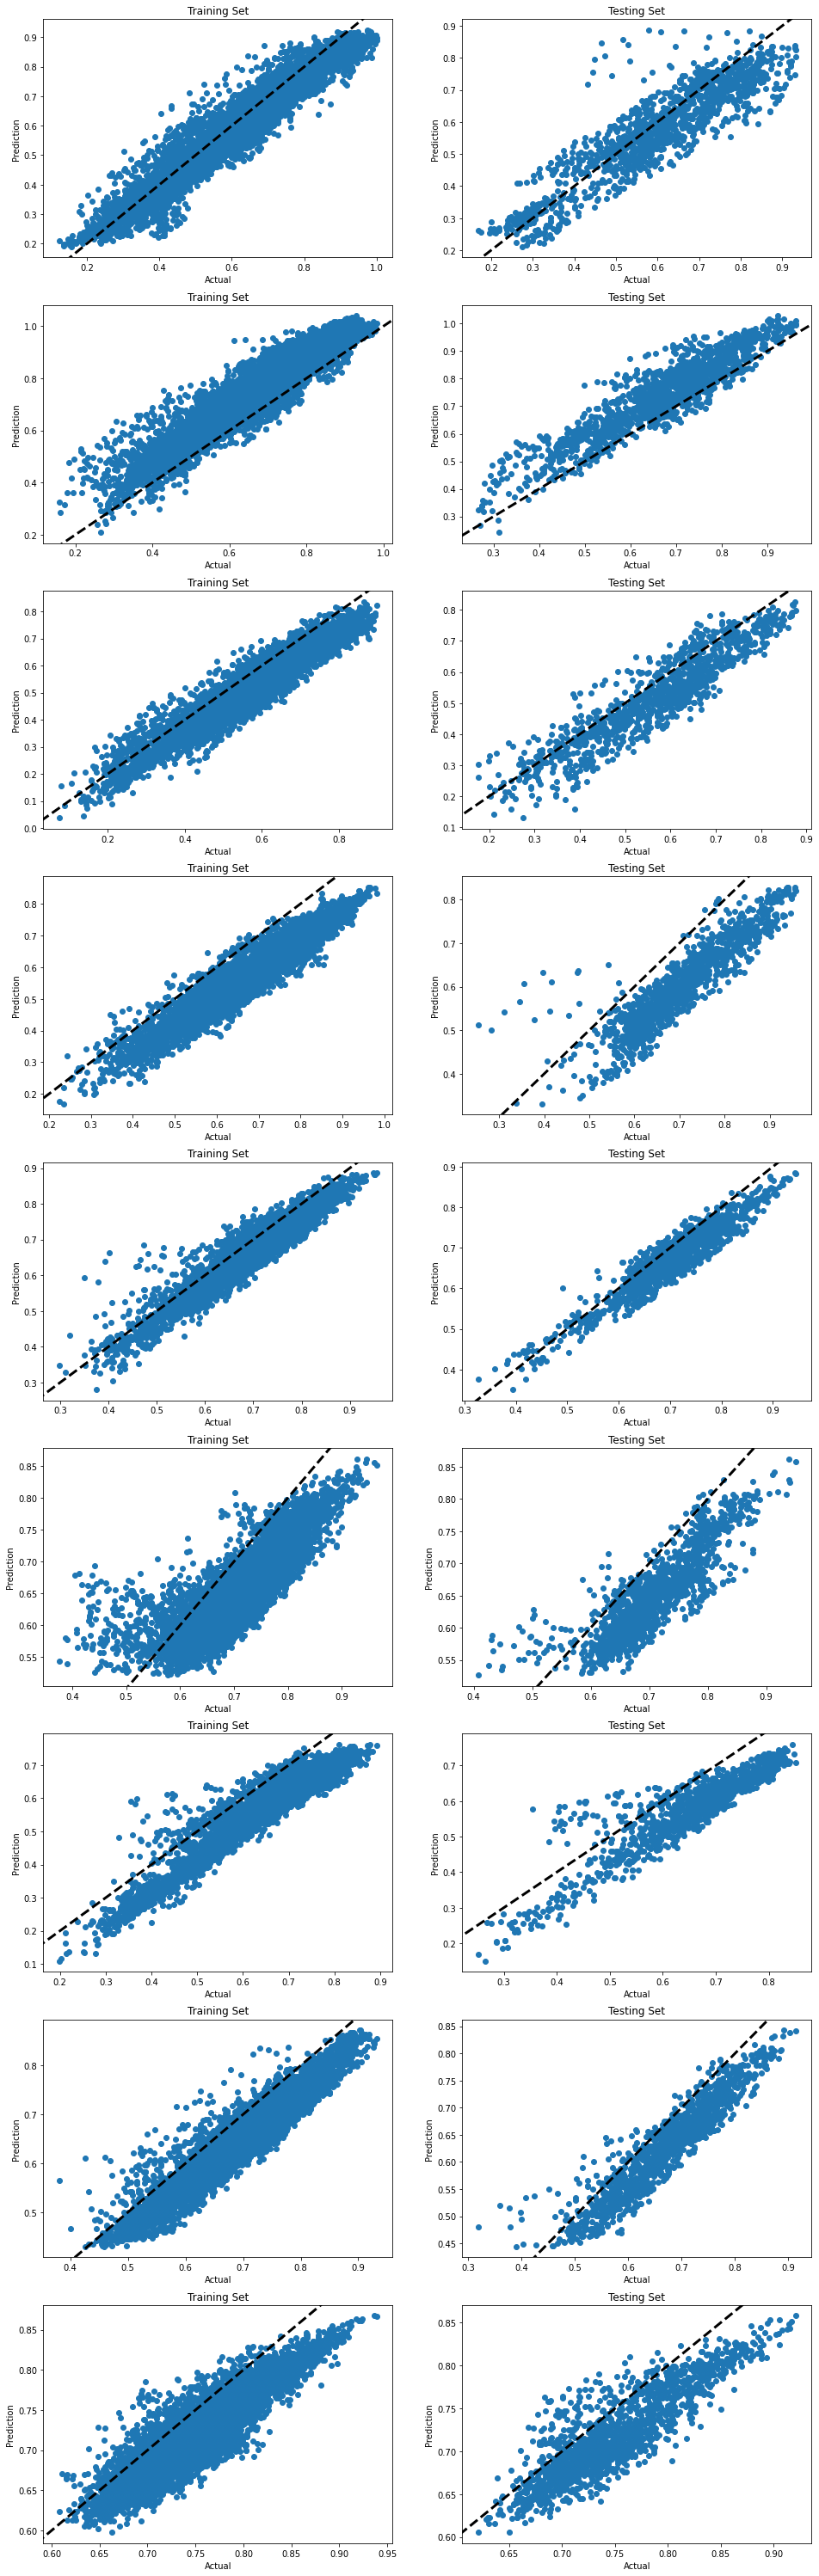

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Daily model no fire features
max_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "max", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.8960641022858793
MAPE: 0.00959095914715739
R2_score: 0.611477056011483


MAE: 4.904188890474758
MAPE: 0.016184057688841607
R2_score: -0.36078170296194684


MAE: 2.0537572382146667
MAPE: 0.006862928927010757
R2_score: 0.7114382374932913


MAE: 1.911683843485516
MAPE: 0.0062444724886802526
R2_score: 0.5978559407561037


MAE: 1.8602525630950941
MAPE: 0.006119125322153386
R2_score: 0.34537976190524416


MAE: 1.8765673962008567
MAPE: 0.006125929373476586
R2_score: 0.34515377939449676


MAE: 1.6301682655071397
MAPE: 0.005410065177299364
R2_score: 0.46689609248003255


MAE: 3.067475090954349
MAPE: 0.010069366312128632
R2_score: -0.4626881428948383


MAE: 1.2647592693328877
MAPE: 0.004116673882987832
R2_score: 0.521417153583407




In [ ]:
## Daily model with existence of fire features
max_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "max", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 3.352309419307003
MAPE: 0.011015091998020761
R2_score: 0.48628098558517807


MAE: 3.066649344951922
MAPE: 0.010154124574567151
R2_score: 0.3527311654921435


MAE: 2.118007088401102
MAPE: 0.007042018489389166
R2_score: 0.6931862554865391


MAE: 1.8357482813517274
MAPE: 0.005997125672623727
R2_score: 0.6387865780124665


MAE: 2.7370520664215094
MAPE: 0.00893858949097257
R2_score: -0.11868273402636424


MAE: 1.1372157234437992
MAPE: 0.00372731703345349
R2_score: 0.7025335948535377


MAE: 2.295011435462689
MAPE: 0.007551198120301281
R2_score: 0.28304224247925985


MAE: 2.242057220818013
MAPE: 0.007357308558304133
R2_score: 0.17598669126378963


MAE: 0.8415326786041263
MAPE: 0.002743458421746426
R2_score: 0.7328162738663191




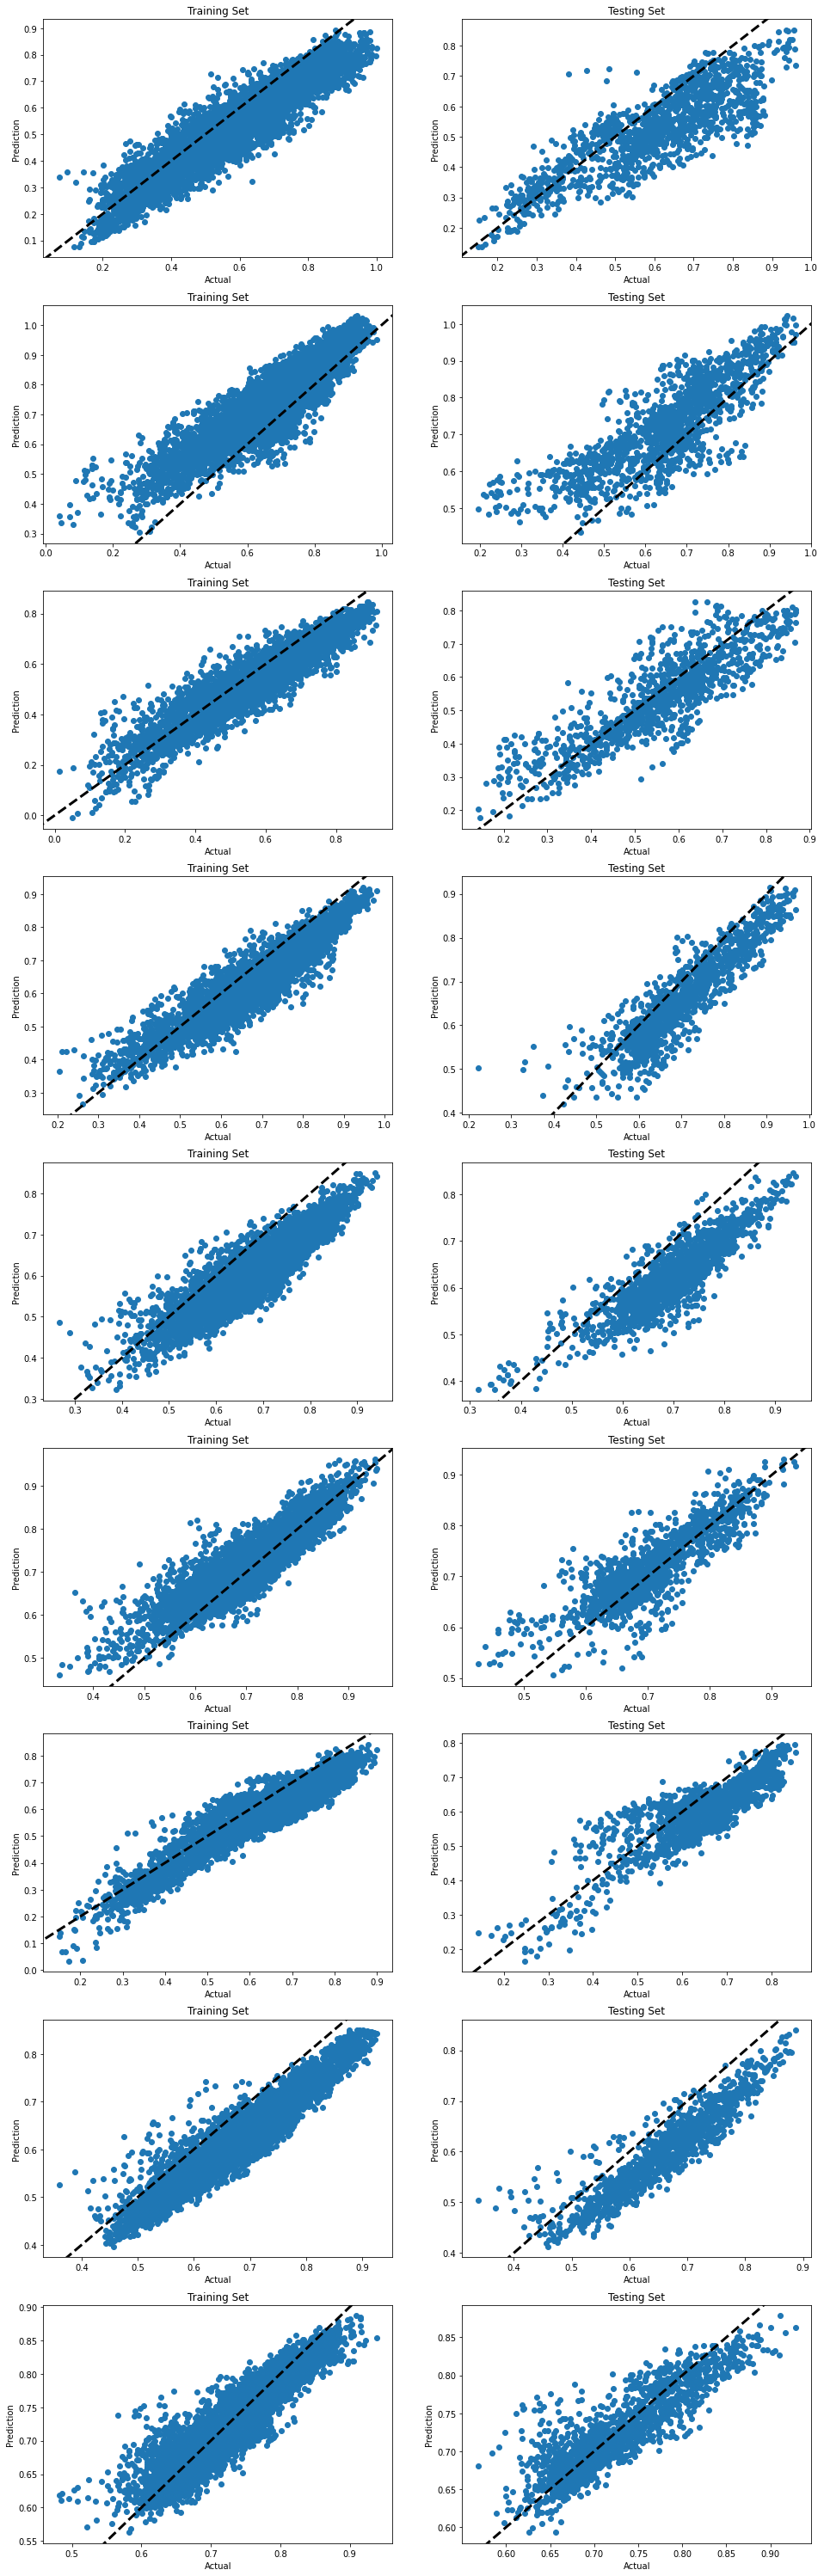

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Daily model no fire features
min_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "min", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.049817194281684
MAPE: 0.00705132343440767
R2_score: 0.7687418313394265


MAE: 3.142571263521634
MAPE: 0.010731447445446893
R2_score: 0.24476633417302898


MAE: 2.2446809020996135
MAPE: 0.007724443877263914
R2_score: 0.6439416914049616


MAE: 1.9615389643351233
MAPE: 0.006664149077087347
R2_score: 0.5271299713410204


MAE: 3.4070480869293203
MAPE: 0.01154948564698165
R2_score: -0.7686088402072939


MAE: 1.46581927411479
MAPE: 0.00499031540137012
R2_score: 0.42896702871161063


MAE: 1.1795565627525597
MAPE: 0.004024652353513217
R2_score: 0.719703149569625


MAE: 4.4060899696499725
MAPE: 0.015025806320005008
R2_score: -2.0363988193384497


MAE: 1.1307715297698968
MAPE: 0.0038263019463769003
R2_score: 0.2147806039346436




In [ ]:
## Daily model with existence of fire features
min_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "min", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.4229048145435472
MAPE: 0.008357986445075412
R2_score: 0.6996935697744681


MAE: 1.9921129334435101
MAPE: 0.006811178141033855
R2_score: 0.6399764926742368


MAE: 1.9395031788219146
MAPE: 0.006694238924255274
R2_score: 0.7177823517110429


MAE: 1.5315860387166333
MAPE: 0.0052128684137608405
R2_score: 0.6714560693056489


MAE: 0.920983188247681
MAPE: 0.003136559623640725
R2_score: 0.8159271550407038


MAE: 2.8726253933814236
MAPE: 0.009767116399013183
R2_score: -0.8085773622410598


MAE: 0.8369380897258892
MAPE: 0.0028639375357448673
R2_score: 0.8082729073613268


MAE: 1.188566524490657
MAPE: 0.004060681399459997
R2_score: 0.6768480373594176


MAE: 0.8029615833282512
MAPE: 0.002710551558718335
R2_score: 0.573855649619264




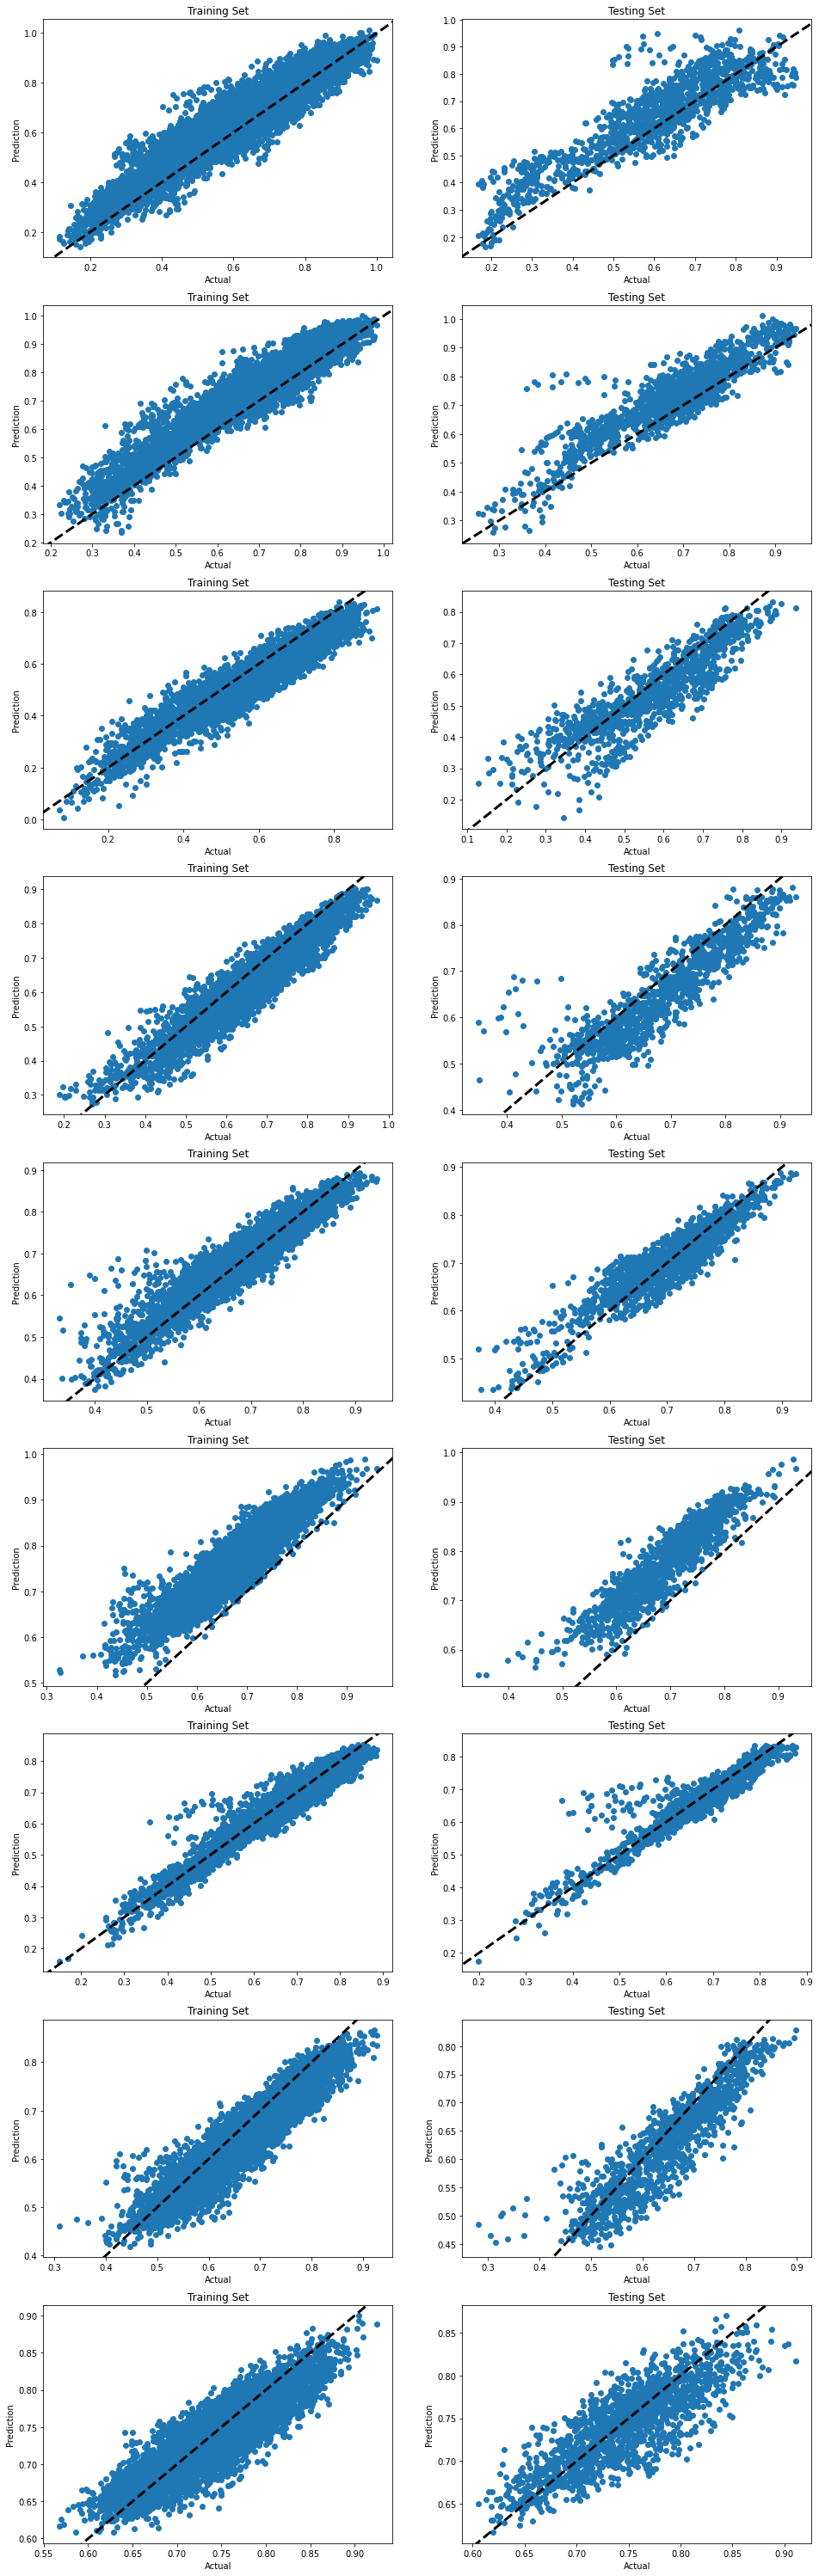

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Monthly model no fire features
temp_monthly_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "monthly", aggregation_type = None,
                                                                      learning_rate = 0.0001, epochs = 60, batch = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7129145
MAPE: 0.0023954026
R-squared: 0.8764873921421007


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.0805112
MAPE: 0.0036590295
R-squared: 0.8655562711408326


MAE: 0.6604615
MAPE: 0.0022312761
R-squared: 0.7366717295041298


MAE: 0.5572992
MAPE: 0.0018568077
R-squared: 0.7925977667834209


MAE: 0.7302405
MAPE: 0.002441884
R-squared: 0.6688721135645239


MAE: 0.52317595
MAPE: 0.0017419143
R-squared: 0.8256213172194935




In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7608775
MAPE: 0.00255324
R-squared: 0.8324394077644601


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.2078652
MAPE: 0.004082369
R-squared: 0.7999430717966762


MAE: 0.6587831
MAPE: 0.0022176094
R-squared: 0.5818930648495219


MAE: 0.61295784
MAPE: 0.002041491
R-squared: 0.6181003921723743


MAE: 0.7864003
MAPE: 0.002631261
R-squared: 0.5189951154348333


MAE: 0.5369337
MAPE: 0.001788335
R-squared: 0.7716890618359499




In [ ]:
## Monthly model with existence of fire features
temp_monthly_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "monthly", aggregation_type = None,
                                                                      learning_rate = 0.0001, epochs = 80, batch = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.5877237
MAPE: 0.0019737787
R-squared: 0.9200723191089646


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 0.8162208
MAPE: 0.002761501
R-squared: 0.9267948806643648


MAE: 0.53802097
MAPE: 0.0018188297
R-squared: 0.8248713702012399


MAE: 0.4976243
MAPE: 0.0016584591
R-squared: 0.834271047541379


MAE: 0.5816958
MAPE: 0.0019456539
R-squared: 0.7808716955207766


MAE: 0.49383476
MAPE: 0.0016445298
R-squared: 0.8454319962382828




In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7026335
MAPE: 0.0023572182
R-squared: 0.867978979246161


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.0011439
MAPE: 0.003382675
R-squared: 0.8730658902340321


MAE: 0.63541204
MAPE: 0.0021390442
R-squared: 0.6418628731518312


MAE: 0.5409086
MAPE: 0.0018022091
R-squared: 0.6787639661983927


MAE: 0.76968193
MAPE: 0.0025763626
R-squared: 0.5329420552441155


MAE: 0.5660349
MAPE: 0.0018858437
R-squared: 0.749855823584933




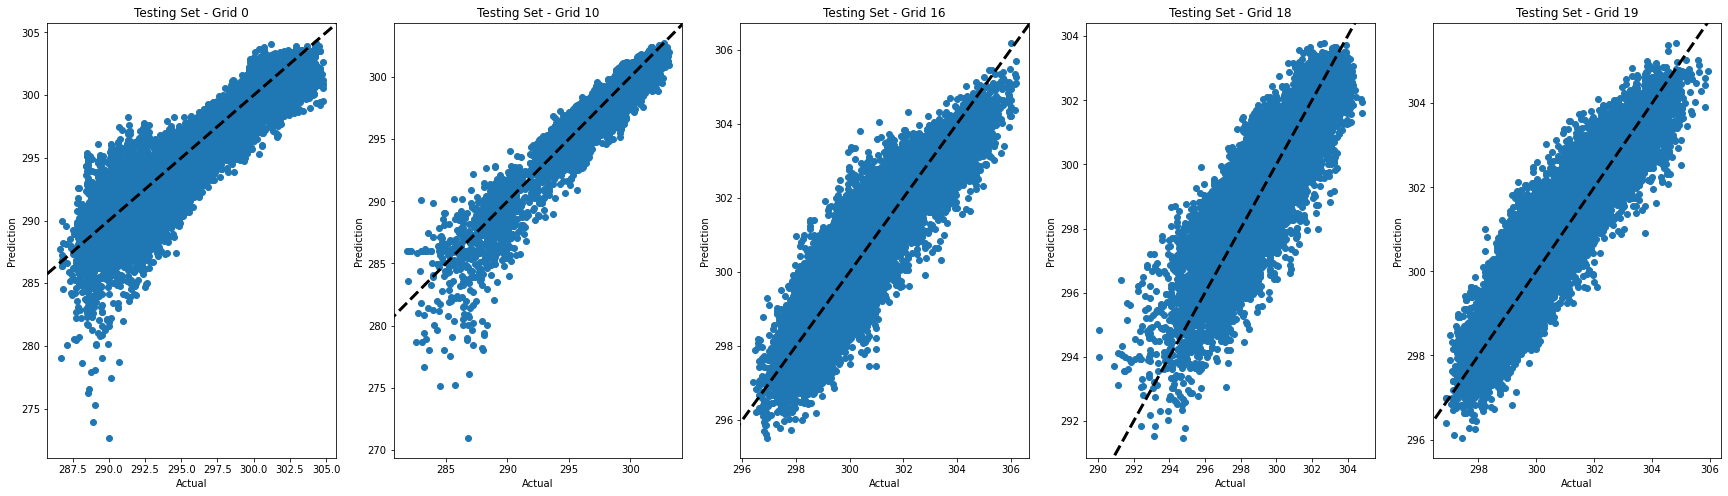

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)
fig, ax = plt.subplots(1, 5)
for n in range(len(selected_grids_monthly)):
    ax[n].scatter(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                  (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                  min_era5_land_monthly['temperature_min'][1], 
                  np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                  (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                  min_era5_land_monthly['temperature_min'][1],
    marker='o')
    lims = [
        np.min([ax[n].get_xlim(), ax[n].get_ylim()]),  # min of both axes
        np.max([ax[n].get_xlim(), ax[n].get_ylim()]),  # max of both axes
    ]
    ax[n].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[n].set_title("Testing Set - " + "Grid " + str(selected_grids[n]))
    ax[n].set_xlabel("Actual")
    ax[n].set_ylabel("Prediction")

#### 5.3) Deep Learning Models (Precipitation Event Prediction & Sum of Precipitation Forecast)

Due to the the fact that values of the ERA5-LAND data were reconstructed or forecasted by climatic models, there could be some insignificantly small outputted values for some variables like precipitation as computed from the estimates, and practically these values had no meanings since rainfall less than 0.01 mm within a day could be somehow neglectable. The weather foreast nowadays usually presented precipitation predictions as a probability indicating how likely it will rain in the following days. Therefore, in the following constructed model classes, a two-step appproach was adopted, and the targets comprised of a binarized pixelwise precipitation event attribute and a ontinuous target of the sum of amounts of rainfalls. 

For daily prediction on the precipitation event, the improvements contributed by adding the wildfire features were small, except for grid 2 and grid 10. Grid 2 had a relatively small percentage of wildfire occurrences while Grid 10 was among the most frequently wildfire-impacted locations, hence the variations might be dependent on local topological and landscape factors, or their interactions and dynamics under wildfire spreads. Unlike the wildfire occurrences in which we focused on the performance of positive pixels, the weighted average of both classes might be better indicator for the precipitaion events as both sides could bring undesirable impacts (flooding and droughts). In terms of the regression on the amounts of precipitations, 5 or 6 grids out of 9 grids had a small extent of improvements on the error rates. For monthly aggregated precipitations, the MAEs achieved was better than the MAEs in daily predictions, while the MAPEs were worse. Adding wildfire features almost had no impact on the error rates, an alternative approach might be needed for the investigations and benchmark of the long-term wildfire-induced effects on meteorological data.

Daily Predictions (Precision, Recall and F1-score weighted average based on the binary class - precipitation occurrences > 1 mm or not)

** N.I. = No Improvement

<table>
  <thead>
  <tr>
      <th></th>
      <th></th>
      <th colspan="8">With no wildfire image features</th>
      <th colspan="8">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.79</td>
      <td>0.81</td>
      <td>0.80</td>
      <td>0.81</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.81</td>
      <td>0.83</td>
      <td>0.81</td>
      <td>0.83</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>0.89</td>
      <td>0.88</td>
      <td>0.87</td>
      <td>0.88</td>
      <td>0.83</td>
      <td>0.85</td>
      <td>0.81</td>
      <td>0.82</td>
      <td>0.89</td>
      <td>0.88</td>
      <td>0.86</td>
      <td>0.88</td>
      <td>0.82</td>
      <td>0.84</td>
      <td>0.79</td>
      <td>0.84</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>0.89</td>
      <td>0.69</td>
      <td>0.74</td>
      <td>0.69</td>
      <td>0.80</td>
      <td>0.56</td>
      <td>0.59</td>
      <td>0.56</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.80</td>
      <td>0.80</td>
      <td>0.80</td>
      <td>0.80</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.94</td>
      <td>0.93</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>0.92</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>0.84</td>
      <td>0.69</td>
      <td>0.70</td>
      <td>0.69</td>
      <td>0.84</td>
      <td>0.66</td>
      <td>0.68</td>
      <td>0.66</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.82</td>
      <td>0.80</td>
      <td>0.81</td>
      <td>0.80</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.93</td>
      <td>0.85</td>
      <td>0.87</td>
      <td>0.85</td>
      <td>0.94</td>
      <td>0.82</td>
      <td>0.85</td>
      <td>0.82</td>
      <td>0.94</td>
      <td>0.92</td>
      <td>0.93</td>
      <td>0.92</td>
      <td>0.93</td>
      <td>0.90</td>
      <td>0.91</td>
      <td>0.90</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
    </tr>
  </tbody>
</table>

Daily Predictions

** N.I. = No Improvement


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>2.07</td>
      <td>3.04%</td>
      <td>0.60</td>
      <td>2.39</td>
      <td>3.49%</td>
      <td>0.41</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>1.77</td>
      <td>3.25%</td>
      <td>0.67</td>
      <td>2.46</td>
      <td>12.98%</td>
      <td>0.29</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>2.40</td>
      <td>3.32%</td>
      <td>0.40</td>
      <td>2.88</td>
      <td>2.72%</td>
      <td>0.16</td>
      <td>1.96</td>
      <td>3.03%</td>
      <td>0.58</td>
      <td>2.68</td>
      <td>2.90%</td>
      <td>0.31</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>1.73</td>
      <td>2.76%</td>
      <td>0.65</td>
      <td>2.35</td>
      <td>1.83%</td>
      <td>0.43</td>
      <td>1.57</td>
      <td>2.60%</td>
      <td>0.72</td>
      <td>2.32</td>
      <td>2.59%</td>
      <td>0.49</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>1.38</td>
      <td>1.82%</td>
      <td>0.81</td>
      <td>1.76</td>
      <td>2.07%</td>
      <td>0.60</td>
      <td>1.39</td>
      <td>1.57%</td>
      <td>0.81</td>
      <td>1.45</td>
      <td>1.60%</td>
      <td>0.67</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>1.89</td>
      <td>3.07%</td>
      <td>0.71</td>
      <td>1.84</td>
      <td>2.95%</td>
      <td>0.70</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>1.46</td>
      <td>3.63%</td>
      <td>0.66</td>
      <td>1.74</td>
      <td>1.81%</td>
      <td>0.58</td>
      <td>1.31</td>
      <td>3.00%</td>
      <td>0.73</td>
      <td>1.58</td>
      <td>1.72%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>1.43</td>
      <td>3.22%</td>
      <td>0.76</td>
      <td>1.42</td>
      <td>1.01%</td>
      <td>0.61</td>
      <td>1.34</td>
      <td>2.63%</td>
      <td>0.78</td>
      <td>1.33</td>
      <td>0.94%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>1.84</td>
      <td>2.01%</td>
      <td>0.70</td>
      <td>2.13</td>
      <td>2.18%</td>
      <td>0.57</td>
      <td>1.12</td>
      <td>1.16%</td>
      <td>0.86</td>
      <td>1.56</td>
      <td>1.43%</td>
      <td>0.68</td>
    </tr>
  </tbody>
</table>

Monthly Predictions  (Total precipitations in the month)

<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>0.47</td>
      <td>4.01%</td>
      <td>0.50</td>
      <td>0.47</td>
      <td>4.05%</td>
      <td>0.44</td>
      <td>0.48</td>
      <td>4.01%</td>
      <td>0.50</td>
      <td>0.48</td>
      <td>4.08%</td>
      <td>0.43</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.39</td>
      <td>3.27%</td>
      <td>0.79</td>
      <td>0.45</td>
      <td>3.89%</td>
      <td>0.70</td>
      <td>0.36</td>
      <td>3.06%</td>
      <td>0.80</td>
      <td>0.40</td>
      <td>3.50%</td>
      <td>0.75</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.46</td>
      <td>4.32%</td>
      <td>0.95</td>
      <td>0.62</td>
      <td>5.90%</td>
      <td>0.88</td>
      <td>0.51</td>
      <td>4.89%</td>
      <td>0.94</td>
      <td>0.60</td>
      <td>5.79%</td>
      <td>0.89</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.58</td>
      <td>5.76%</td>
      <td>0.90</td>
      <td>0.72</td>
      <td>6.94%</td>
      <td>0.80</td>
      <td>0.57</td>
      <td>5.69%</td>
      <td>0.90</td>
      <td>0.71</td>
      <td>6.91%</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.45</td>
      <td>4.19%</td>
      <td>0.90</td>
      <td>0.51</td>
      <td>4.73%</td>
      <td>0.87</td>
      <td>0.48</td>
      <td>4.42%</td>
      <td>0.90</td>
      <td>0.55</td>
      <td>5.03%</td>
      <td>0.86</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 3):  precipitation forecast
##  3.1) binarized precipitation event classification (i.e. less than 1 mm grouped as "no rain" class)
##  3.2) total amounts of precipitation

## i)  only ERA5 weather features without wildfire / vegetation index features
## ii) ERA5 weather features with wildfire / vegetation index features

def train_predict_precipitation(is_wildfire_features, mode, logit,
                                learning_rate, epochs, batch):

    ## self-defined parameters depending on the depth of features
    if logit == True:
        if is_wildfire_features == True:
            depth = 114
            n_encoder = 5
            n_decoder = 4
        else:
            depth = 50
            n_encoder = 2
            n_decoder = 4
    else:
        if is_wildfire_features == True:
            depth = 114
            n_encoder = 3
            n_decoder = 4
        else:
            depth = 50
            n_encoder = 1
            n_decoder = 4

    if mode == "daily":

        if logit == True:
            ## deploy or call the model class
            model_instance = BiConvLSTM_Attention_Model_Events(
                                mode="daily", img_height=560, img_width=560, 
                                output_img_height=7, output_img_width=7, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40)
            
            ## load daily "precipitation" target array file from folder path at this point
            data_y = prec_sum_binary_daily
        else:
            ## deploy or call the model class
            model_instance = BiConvLSTM_Attention_Model_Weather(
                                mode="daily", img_height=560, img_width=560, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40)
            
            ## load daily "precipitation" target array file from folder path at this point
            data_y = prec_sum_scaled_daily

        prec_daily = []
        for grid in range(len(selected_grids_daily)):
            grid_prec_daily = model_instance
            prec_daily.append(grid_prec_daily)
        
        prec_daily_model = []
        pred_train = []
        pred_test = []

        for grid in range(len(selected_grids_daily)):
            
            data_y = data_y[grid]
            train_y = data_y[train_index[grid]]
            val_y = data_y[val_index[grid]]
            test_y = data_y[test_index[grid]]

            model = prec_daily[grid].get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
            if logit == True:
                model.compile(loss = "binary_crossentropy", 
                              optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                              metrics = ['Accuracy','TruePositives','Precision'])
            else:
                model.compile(loss = "mse", 
                              optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                              metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
            model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])
            prec_daily_model.append(model)

            pred_train.append([train_y, prec_daily_model[grid].predict(train_x, batch_size = batch)])
            pred_test.append([test_y, prec_daily_model[grid].predict(test_x, batch_size = batch)])

        outputted_model = prec_daily_model

    elif mode == "monthly":

        if logit == True:
            ## deploy or call the model class
            prec_monthly = BiConvLSTM_Attention_Model_Events(
                                    mode="monthly", img_height=1120, img_width=1120, 
                                    output_img_height=56, output_img_width=56, 
                                    lag_window=6, neighbour_window=5,
                                    land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                    weather_window_height=50, weather_window_width=40)
            ## load monthly "precipitation" target array file from folder path at this point
            data_y = prec_sum_binary_monthly
        else:
            prec_monthly = BiConvLSTM_Attention_Model_Weather(
                                    mode="monthly", img_height=1120, img_width=1120, 
                                    lag_window=6, neighbour_window=5,
                                    land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                    weather_window_height=50, weather_window_width=40)
            ## load monthly "precipitation" target array file from folder path at this point
            data_y = prec_sum_scaled_monthly

        pred_train = []
        pred_test = []

        data_y = data_y[selected_grids_monthly]
        train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
        val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
        test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

        prec_monthly_model = prec_monthly.get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
        if logit == True:
            prec_monthly_model.compile(loss = "binary_crossentropy", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                          metrics = ['Accuracy','TruePositives','Precision'])
        else:
            prec_monthly_model.compile(loss = "mse", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                          metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
        prec_monthly_model.fit(train_x, train_y, epochs=100, batch_size=4,
                              validation_data = (val_x, val_y),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

        pred_train.append([train_y, prec_monthly_model.predict(train_x, batch_size = 4)])
        pred_test.append([test_y, prec_monthly_model.predict(test_x, batch_size = 4)])

        outputted_model = prec_monthly_model

    return outputted_model, pred_train, pred_test

In [ ]:
## Daily model no fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "daily", logit = True,
                                                                      learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5986
           1       0.91      0.69      0.79      1589

    accuracy                           0.92      7575
   macro avg       0.92      0.84      0.87      7575
weighted avg       0.92      0.92      0.92      7575



              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7389
           1       0.91      0.44      0.59      1761

    accuracy                           0.88      9150
   macro avg       0.90      0.71      0.76      9150
weighted avg       0.89      0.88      0.87      9150



              precision    recall  f1-score   support

           0       0.99      0.65      0.78      5175
           1       0.33      0.96      0.49       950

    accuracy                           0.69      6125
   macro avg       0.66      0.80      0.64      6125
weighted avg       0.89      0.69      0.74      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1090
           1       0.53      0.36      0.43       260

    accuracy                           0.81      1350
   macro avg       0.69      0.64      0.66      1350
weighted avg       0.79      0.81      0.80      1350



              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1329
           1       0.71      0.26      0.38       296

    accuracy                           0.85      1625
   macro avg       0.78      0.62      0.64      1625
weighted avg       0.83      0.85      0.81      1625



              precision    recall  f1-score   support

           0       0.94      0.47      0.62       858
           1       0.32      0.89      0.47       242

    accuracy                           0.56      1100
   macro avg       0.63      0.68      0.55      1100
weighted avg       0.80      0.56      0.59      1100



             

In [ ]:
## Daily model with existence of fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "daily", logit = True,
                                                                      learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5986
           1       0.90      0.60      0.72      1589

    accuracy                           0.90      7575
   macro avg       0.90      0.79      0.83      7575
weighted avg       0.90      0.90      0.89      7575



              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7389
           1       0.97      0.41      0.57      1761

    accuracy                           0.88      9150
   macro avg       0.92      0.70      0.75      9150
weighted avg       0.89      0.88      0.86      9150



              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5175
           1       0.82      0.85      0.84       950

    accuracy                           0.95      6125
   macro avg       0.90      0.91      0.90      6125
weighted avg       0.95      0.95      0.95      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1090
           1       0.59      0.34      0.43       260

    accuracy                           0.83      1350
   macro avg       0.72      0.64      0.67      1350
weighted avg       0.81      0.83      0.81      1350



              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1329
           1       0.74      0.17      0.28       296

    accuracy                           0.84      1625
   macro avg       0.79      0.58      0.59      1625
weighted avg       0.82      0.84      0.79      1625



              precision    recall  f1-score   support

           0       0.87      0.87      0.87       858
           1       0.54      0.53      0.54       242

    accuracy                           0.80      1100
   macro avg       0.71      0.70      0.71      1100
weighted avg       0.80      0.80      0.80      1100



             

In [ ]:
## Daily model no fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "daily", logit = False,
                                                                      learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.0696374094842964
MAPE: 3.0389416917278527
R2_score: 0.5971109412598374


MAE: 1.771733365912439
MAPE: 3.2534732703136924
R2_score: 0.6720415268266398


MAE: 2.404884442135763
MAPE: 3.320309505385834
R2_score: 0.4042887091677833


MAE: 1.7305299044225884
MAPE: 2.758102985316989
R2_score: 0.6548609315498246


MAE: 1.3800306794921788
MAPE: 1.8156090871568902
R2_score: 0.8137758913244523


MAE: 1.8918970688214143
MAPE: 3.066102413326176
R2_score: 0.7122400342098877


MAE: 1.4599602611129936
MAPE: 3.634305352349682
R2_score: 0.6637679827568874


MAE: 1.4306700742445941
MAPE: 3.220869096015897
R2_score: 0.7585384237367667


MAE: 1.8434986403558262
MAPE: 2.012973157447658
R2_score: 0.7000375946897841




In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.3869242988688844
MAPE: 3.48533570011043
R2_score: 0.40757215505684613


MAE: 2.460781202041775
MAPE: 12.974710781547515
R2_score: 0.29209031611559655


MAE: 2.8765962840755845
MAPE: 2.717863351117332
R2_score: 0.1594904316322627


MAE: 2.354650984528827
MAPE: 1.8285509855850188
R2_score: 0.4267984905922684


MAE: 1.7602116418493097
MAPE: 2.0749243130560457
R2_score: 0.5957203073358697


MAE: 1.8353047935172615
MAPE: 2.9536808984608403
R2_score: 0.6978423101708389


MAE: 1.7408559345718608
MAPE: 1.81099205972367
R2_score: 0.57721435973334


MAE: 1.422960396484155
MAPE: 1.0089986807649958
R2_score: 0.610767493539655


MAE: 2.128201227165148
MAPE: 2.1750136488216842
R2_score: 0.570728434103449




In [ ]:
## Daily model with existence of fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "daily", logit = False,
                                                                      learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.9448010008341208
MAPE: 2.322655764990462
R2_score: 0.22749762224874906


MAE: 2.3623818615029193
MAPE: 4.871090347898946
R2_score: 0.4820725030275782


MAE: 1.9596567883345417
MAPE: 3.033349831632474
R2_score: 0.5810655922316271


MAE: 1.5666729948297882
MAPE: 2.5971776508831543
R2_score: 0.7210797379605741


MAE: 1.387721654886979
MAPE: 1.5748057204112413
R2_score: 0.8081613868849896


MAE: 1.9882145275963985
MAPE: 3.5610205441600398
R2_score: 0.664414479466309


MAE: 1.30659602368015
MAPE: 2.997190193445883
R2_score: 0.7255419528794148


MAE: 1.3387562821290693
MAPE: 2.6287073533141037
R2_score: 0.7750399623786669


MAE: 1.1184154522460863
MAPE: 1.162978591669434
R2_score: 0.8624349975112241




In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 3.113773612806783
MAPE: 2.8132042179701484
R2_score: -0.05192076590484364


MAE: 2.927195835556704
MAPE: 18.36008888150888
R2_score: 0.06989951804721027


MAE: 2.6853693851500977
MAPE: 2.9050871163231475
R2_score: 0.3051965257348472


MAE: 2.317532635869999
MAPE: 2.5931191687845523
R2_score: 0.48594639672084533


MAE: 1.4536311026926148
MAPE: 1.6025229956161255
R2_score: 0.6726075812774113


MAE: 1.8539113849187439
MAPE: 3.233706846403661
R2_score: 0.6823502718955402


MAE: 1.5810217881552109
MAPE: 1.717425071592826
R2_score: 0.643177690007137


MAE: 1.3266260570461412
MAPE: 0.9413413887569329
R2_score: 0.6397758404195454


MAE: 1.5626754873362494
MAPE: 1.4315714904355554
R2_score: 0.6811652803709086




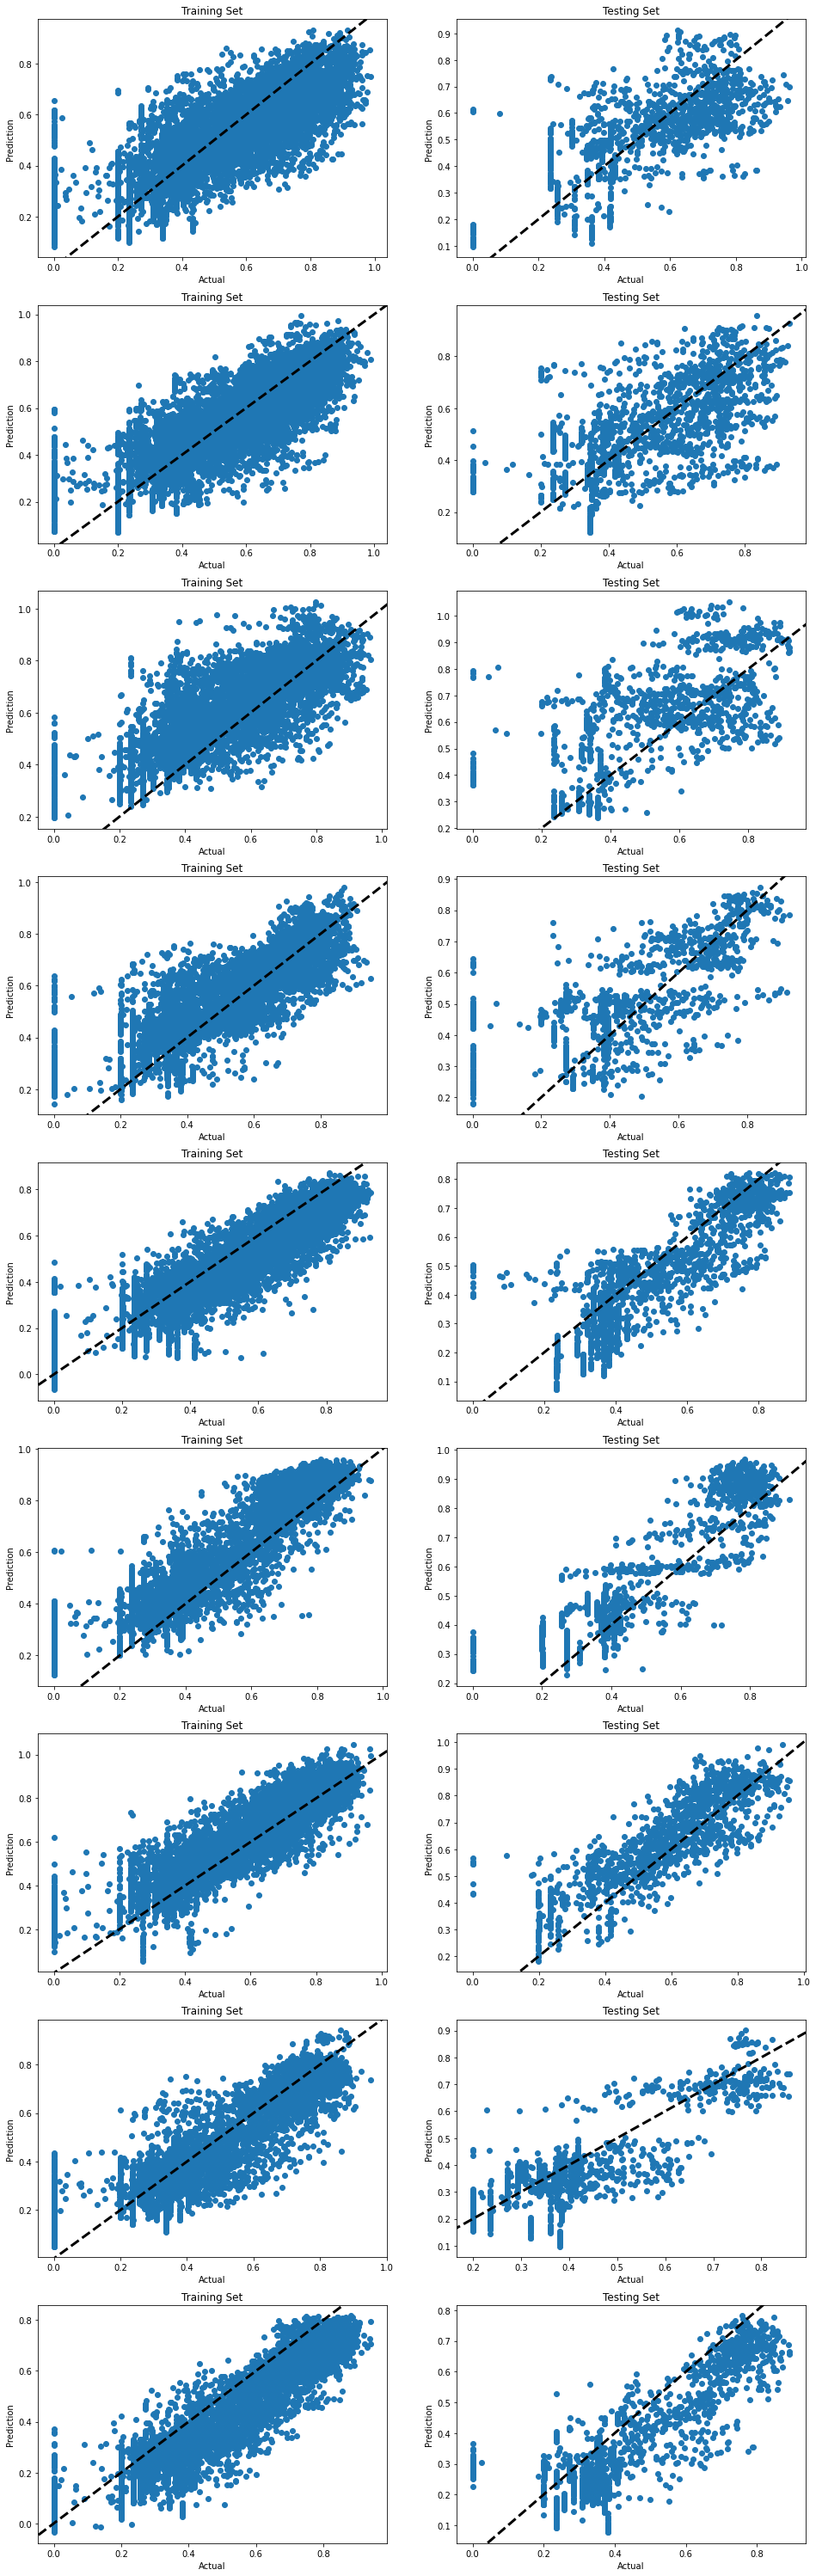

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Monthly model no fire features
prec_monthly_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "monthly", logit = False,
                                                                        learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))

MAE: 0.4688161
MAPE: 0.043094475
R-squared: 0.913160135281894


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("\n")

MAE: 0.46853116
MAPE: 0.0400737
R-squared: 0.504531326119196


MAE: 0.390158
MAPE: 0.032721978
R-squared: 0.7860840392737948


MAE: 0.45714927
MAPE: 0.043230522
R-squared: 0.9469418299284427


MAE: 0.5835327
MAPE: 0.05762555
R-squared: 0.8968800396418636


MAE: 0.44538882
MAPE: 0.041925382
R-squared: 0.9037242783714715




In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))

MAE: 0.55380136
MAPE: 0.05108851
R-squared: 0.8612403456680109


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("\n")

MAE: 0.4700663
MAPE: 0.040457558
R-squared: 0.435122163065092


MAE: 0.45051894
MAPE: 0.03889455
R-squared: 0.6991174505822612


MAE: 0.6158842
MAPE: 0.058998406
R-squared: 0.8849979022302167


MAE: 0.71937114
MAPE: 0.06936289
R-squared: 0.8021320721326413


MAE: 0.5104068
MAPE: 0.047275335
R-squared: 0.8718458756137873




In [ ]:
## Monthly model with existence of fire features
prec_monthly_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "monthly", logit = False,
                                                                        learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))

MAE: 0.4808095
MAPE: 0.044186812
R-squared: 0.9089509235631776


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("\n")

MAE: 0.47669786
MAPE: 0.040054686
R-squared: 0.504116409860215


MAE: 0.36357757
MAPE: 0.030558296
R-squared: 0.8030748965538249


MAE: 0.5118504
MAPE: 0.04888473
R-squared: 0.936728907463565


MAE: 0.5740539
MAPE: 0.056877606
R-squared: 0.8954635550518626


MAE: 0.47552255
MAPE: 0.04417523
R-squared: 0.8955866690055871




In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))

MAE: 0.550181
MAPE: 0.050700594
R-squared: 0.8667190460908665


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("\n")

MAE: 0.48001876
MAPE: 0.04076212
R-squared: 0.4270019951892287


MAE: 0.39881283
MAPE: 0.03500255
R-squared: 0.750599392850003


MAE: 0.60409623
MAPE: 0.057924695
R-squared: 0.8941989959422605


MAE: 0.7130381
MAPE: 0.0691273
R-squared: 0.8063896835354645


MAE: 0.55255574
MAPE: 0.05029671
R-squared: 0.8568942395202707




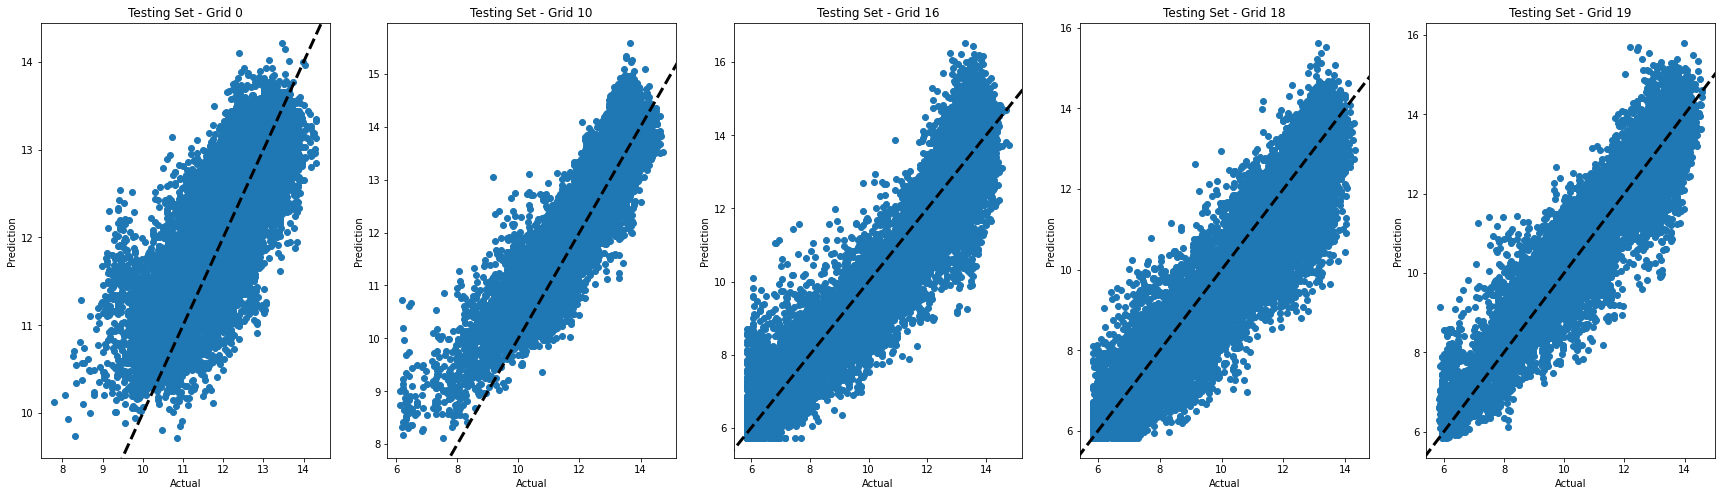

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)
fig, ax = plt.subplots(1, 5)
for n in range(len(selected_grids_monthly)):
    ax[n].scatter(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        marker='o')
    lims = [
        np.min([ax[n].get_xlim(), ax[n].get_ylim()]),  # min of both axes
        np.max([ax[n].get_xlim(), ax[n].get_ylim()]),  # max of both axes
    ]
    ax[n].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[n].set_title("Testing Set - " + "Grid " + str(selected_grids[n]))
    ax[n].set_xlabel("Actual")
    ax[n].set_ylabel("Prediction")